# i. BUSINESS JOB DESCRIPTION


*   Our client is an Insurance Company that has provided health insurance to its customers. Now, they are analyzing the possibility of offering a new product in order to profit from cross selling: Vehicular Insurance.

*   An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

*   Cross selling is the practice that involves the selling of related products. In this case, it is a way of increasing both revenue and customer loyalty, thus improving a customer's lifetime value/retention.


# ii. THE CHALLENGE

*   We were hired as data scientists consultants, with goals to build a model that predicts whether our client's customer would also be interested in auto insurance.

*   With the solution, the company can then accordingly plan its communication strategy to reach out those customers thus optimizing its business model by only making contact with those customers who are most likely to make the purchase.

*   In order to understand our client's customers behaviours, we have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel), which will be used further for the construction of our Machine Larning Prediction model. This overall data was obtained upon a survey with about 380,000 customers, with response about their interest in joining a new auto insurance program.

# iii. BUSINESS QUESTIONS

*   What are the main insights on the most relevant attributes of relevants customers in purchasing vehicular insurance?

*   What percentage of customers are interested in purchasing vehicular insurance, given the constraint of making only 20,000 calls?






# 0.0 IMPORTS, FUNCTIONS AND CONNECTIONS

In [1]:
!pip install scikit-plot


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install optuna


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## 0.1 PACKAGES AND LIBRARIES

In [3]:
import pandas       as pd
import numpy        as np
import psycopg2     as pg
import seaborn      as sns
import scikitplot   as skplt
import xgboost      as xgb
import lightgbm     as lgbm
import optuna
import pickle
import warnings
import dotenv
import os

from matplotlib     import pyplot as plt
from collections    import Counter
from sqlalchemy     import create_engine

from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, StratifiedKFold, KFold
from sklearn.metrics            import log_loss

from imblearn.ensemble          import BalancedRandomForestClassifier
from imblearn.pipeline          import Pipeline
from imblearn.combine           import SMOTEENN
from imblearn.under_sampling    import EditedNearestNeighbours

from optuna.integration     import XGBoostPruningCallback
from optuna.visualization   import plot_param_importances
from optuna.pruners         import MedianPruner

from IPython.core.display import HTML
from IPython.display      import Image

## 0.2 Helper Function

In [4]:
from xgboost.sklearn import XGBClassifier
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

def top_k_precision(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})

    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['ranking'] = df.index + 1
    df['precision_top_k'] = df['true'].cumsum()/df['ranking']

    if return_df:
        return df.loc[k, 'precision_top_k'], df
    else:
        return df.loc[k, 'precision_top_k']

def top_k_recall(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})

    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['ranking'] = df.index + 1
    df['recall_top_k'] = df['true'].cumsum()/df['true'].sum()

    if return_df:
        return df.loc[k, 'recall_top_k'], df

    else:
        return df.loc[k, 'recall_top_k']

def top_k_f1score(y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

def ml_top_k_scores(model_name, y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)
    f1 = top_k_f1score(y_true, y_score, k)

    return pd.DataFrame({'Precision_at_k': np.round(precision, 4),
                         'Recall_at_k': np.round(recall, 4),
                         'F1_at_k': np.round(f1, 4)},
                        index=[model_name])

def ml_cv(model_name, model, X, y):
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=32)

    precision_k = []
    recall_k = []
    F1_score_k = []
    for idx, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        #print(f'Fold k-{idx}')
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
        steps = [('r', resample), ('m', model)]
        pipeline_model = Pipeline(steps=steps).fit(X_train, y_train)

        yhat_model = pipeline_model.predict_proba( X_test )

        precision = top_k_precision(y_test, yhat_model, 20000)
        recall = top_k_recall(y_test, yhat_model, 20000)
        F1_score = top_k_f1score(y_test, yhat_model, 20000)

        precision_k.append(precision)
        recall_k.append(recall)
        F1_score_k.append(F1_score)

    return pd.DataFrame({'Model Name': model_name,
                         'Precision@k': f"{round(np.mean(precision_k), 2)} +/- {round(np.std(precision_k), 5)}",
                         'Recall@k': f"{round(np.mean(recall_k), 2)} +/- {round(np.std(recall_k), 5)}",
                         'F1_score@k': f"{round(np.mean(F1_score_k), 2)} +/- {round(np.std(F1_score_k), 5)}"},
                         index = [0])

def objective(trial, X, y, k):
    '''
    Conventional optimization function
    signature for optuna
    '''

    params ={ 'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
              'max_depth': trial.suggest_int('max_depth', 1, 12, step=2),
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'n_estimators': trial.suggest_int('n_estimators', 50, 450, step=50),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=2),
              'scale_pos_weight': trial.suggest_int('scale_pos_weight',6,10),
              'subsample': trial.suggest_float('subsample', 0.01, 1.0, step=0.1),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, step=0.1),
              'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
              'random_state': 32}

    cv = StratifiedKFold(n_splits = 4, shuffle=True, random_state=32)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        #pruning_callback = XGBoostPruningCallback(trial, 'auc')

        #Train The XGBoost Model
        model = xgb.XGBClassifier(**params)
        model.fit(X_train,
                  y_train)
                  #eval_set = [(X_test, y_test)],
                  #early_stopping_rounds=100,
                  #callbacks=[pruning_callback])

        #Model Predict
        preds = model.predict_proba(X_test)
        cv_scores = top_k_recall(y_test, preds, 20000)

    return cv_scores

In [5]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database Connections

### 0.3.1 Database load files (sqlalchemy and psycopg2)

* This section shows the connection and query procedures used for initial data gathering.
* The code is shown as commentary string for research purposes, as it was choosen to load the dataset .csv file locally for better speed on aplication.

In [6]:
#dotenv.load_dotenv(dotenv.find_dotenv())
#url_sql = os.getenv('url_sql')
#engine = create_engine(url_sql)

#host = os.getenv('PA004_HOST')
#port = os.getenv('PA004_PORT')
#dbname = os.getenv('PA004_DATABASE')
#username = os.getenv('PA004_USERNAME')
#password = os.getenv('PA004_PASSWORD')

#conn = pg.connect(host=host, port=port, dbname=dbname, user=username, password=password)

#cur = conn.cursor()

In [7]:
#sql_query = '''
#SELECT u.id, u.age, u.region_code, u.policy_sales_channel,
#       i.previously_insured, i.annual_premium, i.vintage, i.response,
#       v.driving_license, v.vehicle_age, v.vehicle_damage
#       FROM pa004.users u LEFT JOIN pa004.insurance i ON (u.id = i.id)
#                          LEFT JOIN pa004.vehicle v  ON (u.id = v.id)
#                          '''
#cur.execute(sql_query)
#df_raw = pd.read_sql_query(sql_query, con=engine)

#cur.close()
#conn.close()

### 0.3.2 Database load files (Pandas)

In [8]:
df_raw = pd.read_csv('datasets/insurance_data.csv')

In [9]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,Female,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,Female,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,Male,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


# 1.0 DATA DESCRIPTION

In [10]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [11]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Types

### 1.2.1 Columns Description


*   Id: Unique ID for the customer.
*   Gender: Gender of the customer.
*   Age: Age of the customer.
*   Driving License: 0, customer does not have DL; 1, customer already has DL.
*   Region Code: Unique code for the region of the customer.
*   Previously Insured: 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance.
*   Vehicle Age: Age of the vehicle.
*   Vehicle Damage: 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past.
*   Anual Premium: The amount customer needs to pay as premium in the year.
*   Policy sales channel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
*   Vintage: Number of Days, customer has been associated with the company.
*   Response: 1, customer is interested; 0, customer is not interested.

### 1.2.2 Data Types Formating

In [12]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

In [13]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

In [14]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,Female,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,Female,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,Male,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


In [15]:
df1['region_code'] = df1['region_code'].astype(np.int64)

df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## 1.3 Check NA

In [16]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

* no nan values to be filled!



## 1.4 Numerical Data Description

In [17]:
# Data Selection
df1_num = df1.select_dtypes(include=['int64', 'float64'])

#Central Tendency
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_descript = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T
df_descript.columns = ['min','max', 'range', 'average', 'median', 'std', 'skew', 'kurtosis']
df_descript

,min,max,range,average,median,std,skew,kurtosis
id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630




*   The average customer age is 39, with its maximum value as 85. Its distribution presents a right skew. (Not a Normal distribution)
*   The region code has negative skew, also noting that there is **not a normal distribution** upon this feature.
*   The mean value for 'previously_insured' is 0.46. Given that this is a binary feature, we can assume our dataset being balanced on this regard.
*   Similar conclusion can be taken to 'vehicle_damage' (mean value of 0,50)
*   On the other hand, the vast majority of the dataset has active driver license (mean value of 0.99).
*   The Range on for 'annual_premium' values is $537535,00. this indicates that there's a great difference on the ammount of price some users pay.
*   The maximum number of days to be with the company is 299 days and 10 days is the minimum.
*   The mean value for our 'response' variable is 0.12, which indicates an unbalaced dataset for clients we want to determine (the ones interested in acquiring vehicular insurance).


## 1.5 Categorical Data Description

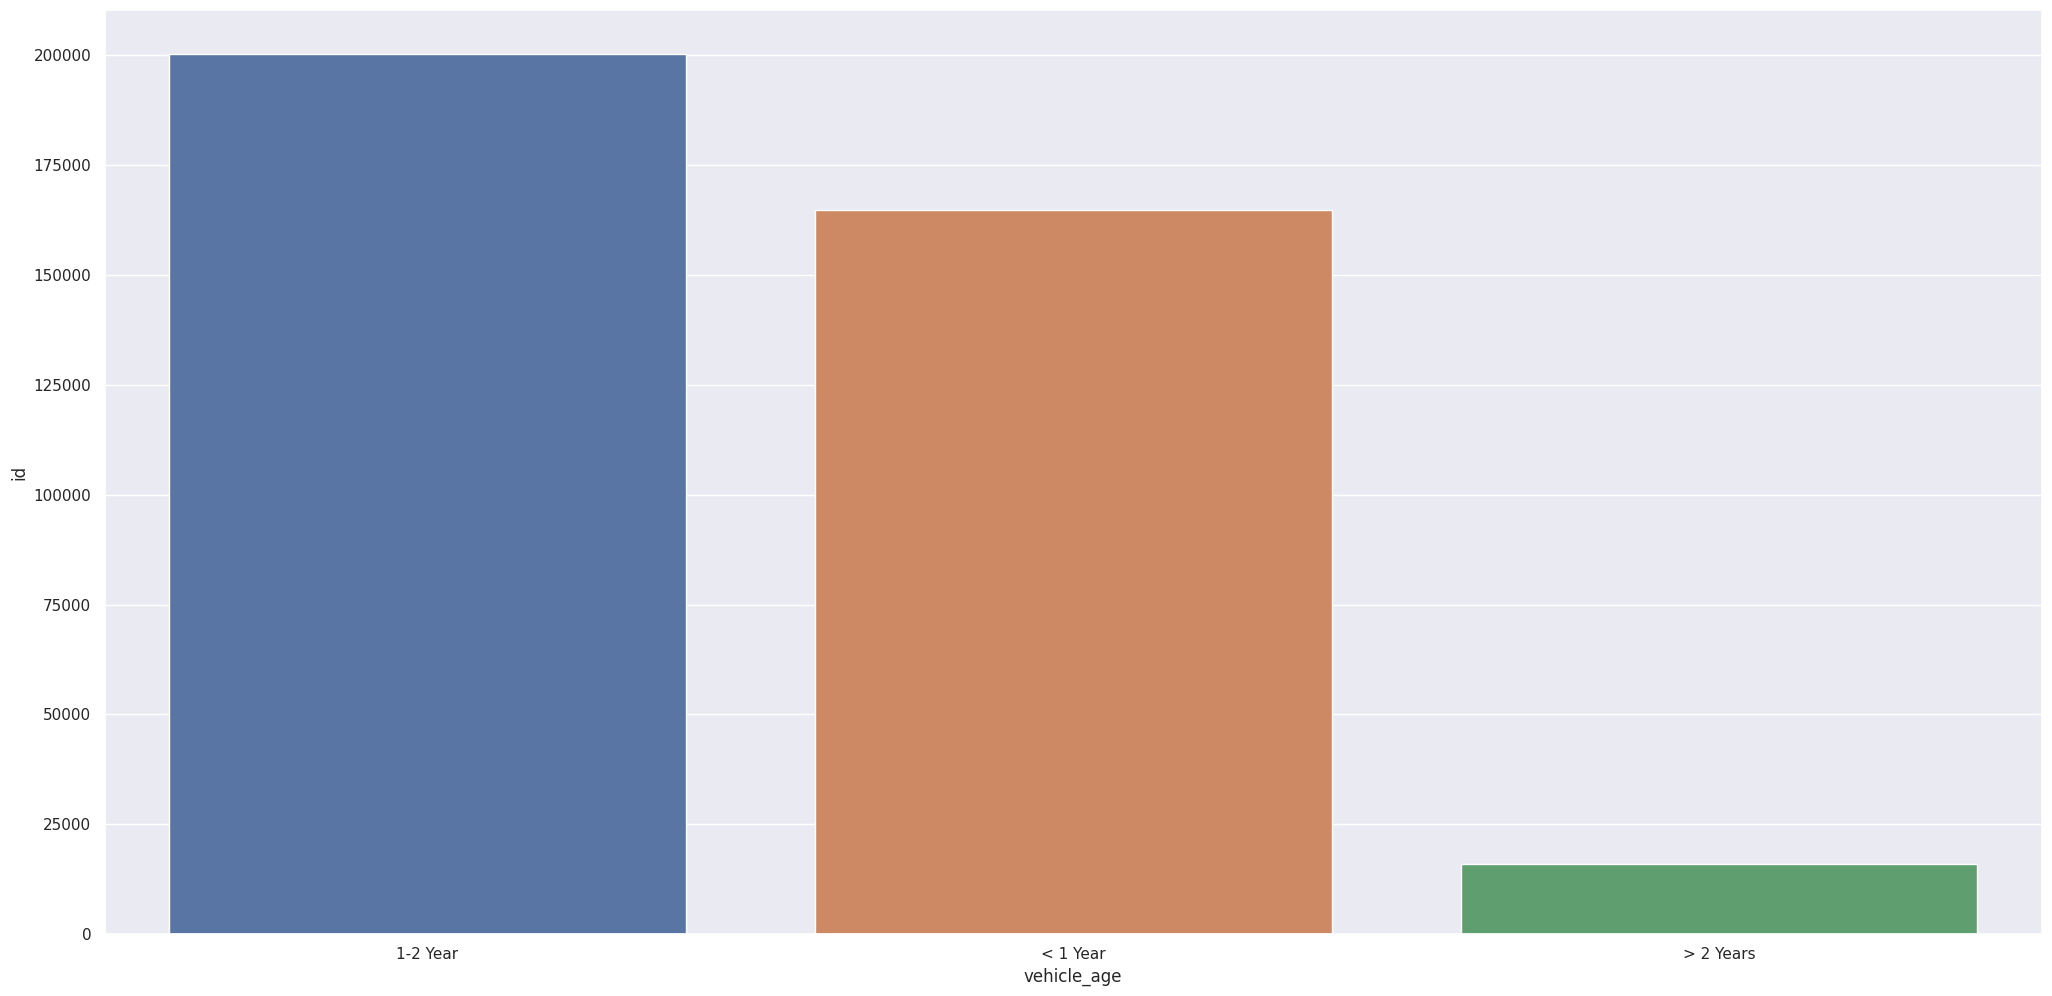

In [18]:
df_cat = df1[['vehicle_age', 'id']].groupby('vehicle_age').count().reset_index()

sns.barplot(data=df_cat, x='vehicle_age', y='id');



*   The most common vehicle age happens between the 1-2 year range.



# 2.0 HYPOTHESIS TEST

In [19]:
df2 = df1.copy()
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'response']

df2 = df2.reindex(columns=reorder_columns)

## 2.1 Hypothesis Mindmap

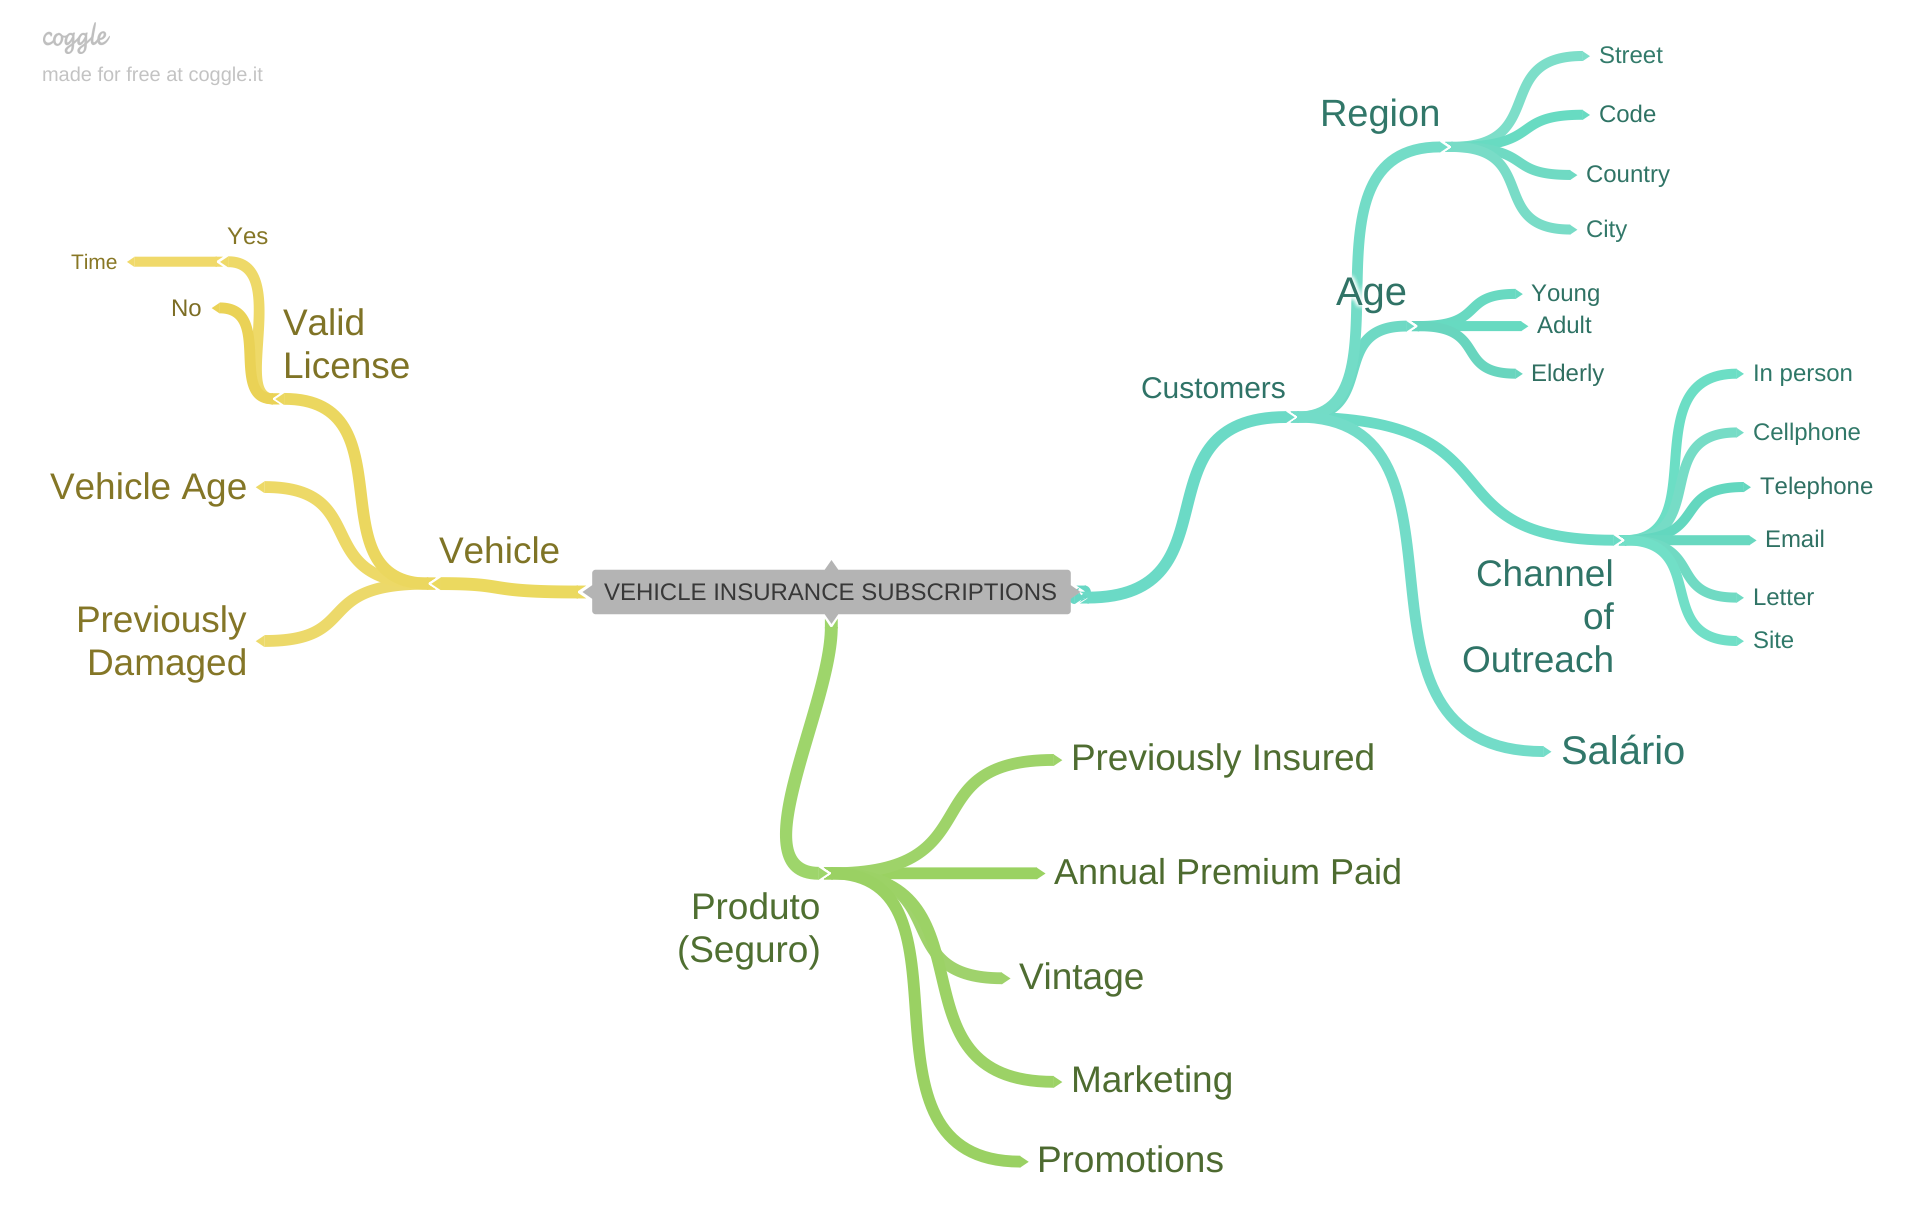

In [20]:
Image('img/MindMapHypothesis.png')

## 2.2 Hypothesis Creation


### 2.2.1 Customer Hypothesis

1. Older clients have are 10% more likely to acquire vehicular insurance.
2. Clients with higher salaries are 10% more likely to acquire vehicle insurance..
3. The closer to a urban center (region code),the higher the propensity to acquire a vehicle insurance

    *Are there any regions with higher incidence of security plans signed?

### 2.2.2 Product Hypothesis

1. Clients who already has a vehicle insurance are 10% less likely to aquire a new insurance plan.
2. Clients with higher annual premium paid are 10% less likely to acquire a vehicular insurance
3. Older clients on the database (Higher vintage count) are 10% more likely to acquire a vehicular insurance.
4. Clients who were exposed to marketing campaigns are 10% more likely to acquired vehicular insurance on cross sell.
5. Clients who are exposed to cross selling special deals are 10% more likely to acquire vehicle insurance.


### 2.2.3 Vehicular Hypothesis

1. Clients with valid drivers license are 10% more likely to acquire a new vehicular insurance.
2. Clients with older vehicles are 10% more likely to acquire a vehicular insurance.
3. Clients whose cehicles were already damaged are 10% more likely to acquire a vehicle insurance.

## 2.3 Selected Hypothesis

1. Older clients have are 10% more likely to acquire vehicular insurance.

2. Clients who already has a vehicle insurance are 10% less likely to aquire a new insurance plan.
3. Clients with higher annual premium paid are 10% less likely to acquire a vehicular insurance
4. Older clients on the database (Higher vintage count) are 10% more likely to acquire a vehicular insurance.

5. Clients with valid drivers license are 10% more likely to acquire a new vehicular insurance.
6. Clients with older vehicles are 10% more likely to acquire a vehicular insurance.
7. Clients whose cehicles were already damaged are 10% more likely to acquire a vehicle insurance.

8. Clients of a particular region are 10% more likely to acquire vehicular insurance.

In [21]:
df2.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,23,11,152,0,23367.0,249,1,< 1 Year,1,0
1,13,41,15,14,1,31409.0,221,1,1-2 Year,0,0
2,18,25,35,152,1,46622.0,299,1,< 1 Year,0,0
3,31,26,8,160,0,2630.0,136,1,< 1 Year,0,0
4,39,45,8,124,0,42297.0,264,1,1-2 Year,1,0


# 3.0 Exploratory Data Analysis & Feature Engineering

In [22]:
df3 = df2.copy()

## 3.1 Univariative Analysis

### 3.1.1 Numerical Variables

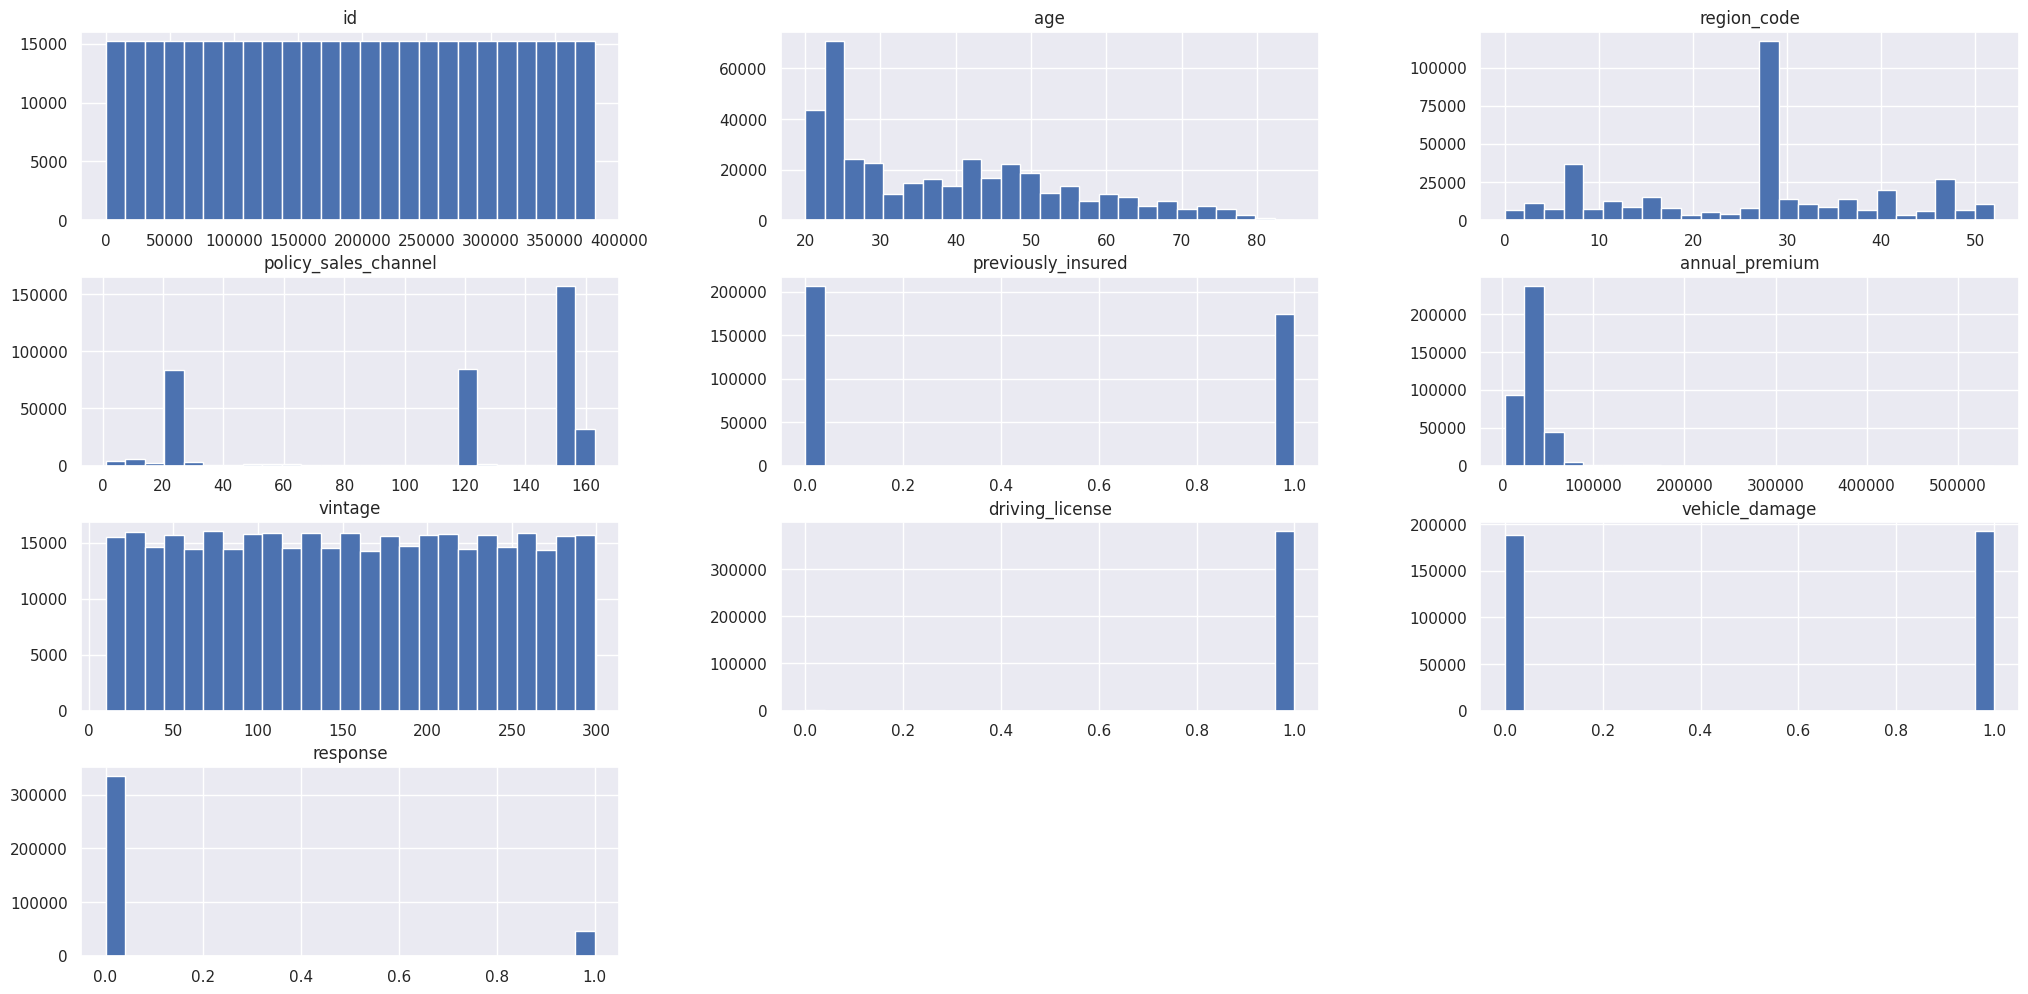

In [23]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])

df3_num.hist(bins=25);



*   Note how unbalaced the dataset is for binary variables 'driving_license', and more importantly, the 'response' variable (which is our class variable).
*   No feature presents a normal distribution. Closest to that is the 'age' variable, which has a light right skew.



### 3.1.2 Categorical Variable

In [24]:
df3['vehicle_age'].drop_duplicates()

0      < 1 Year
1      1-2 Year
27    > 2 Years
Name: vehicle_age, dtype: object

# 3.2 Bivariative Analysis

### 3.2.1 Exploratory Data Analysis (EDA)

### H.1 Older clients have are 10% more likely to acquire vehicular insurance.
**True** -> There is a higher concentration of clients within the 40~50 year range that show interest in acquiring vehicular insurance.

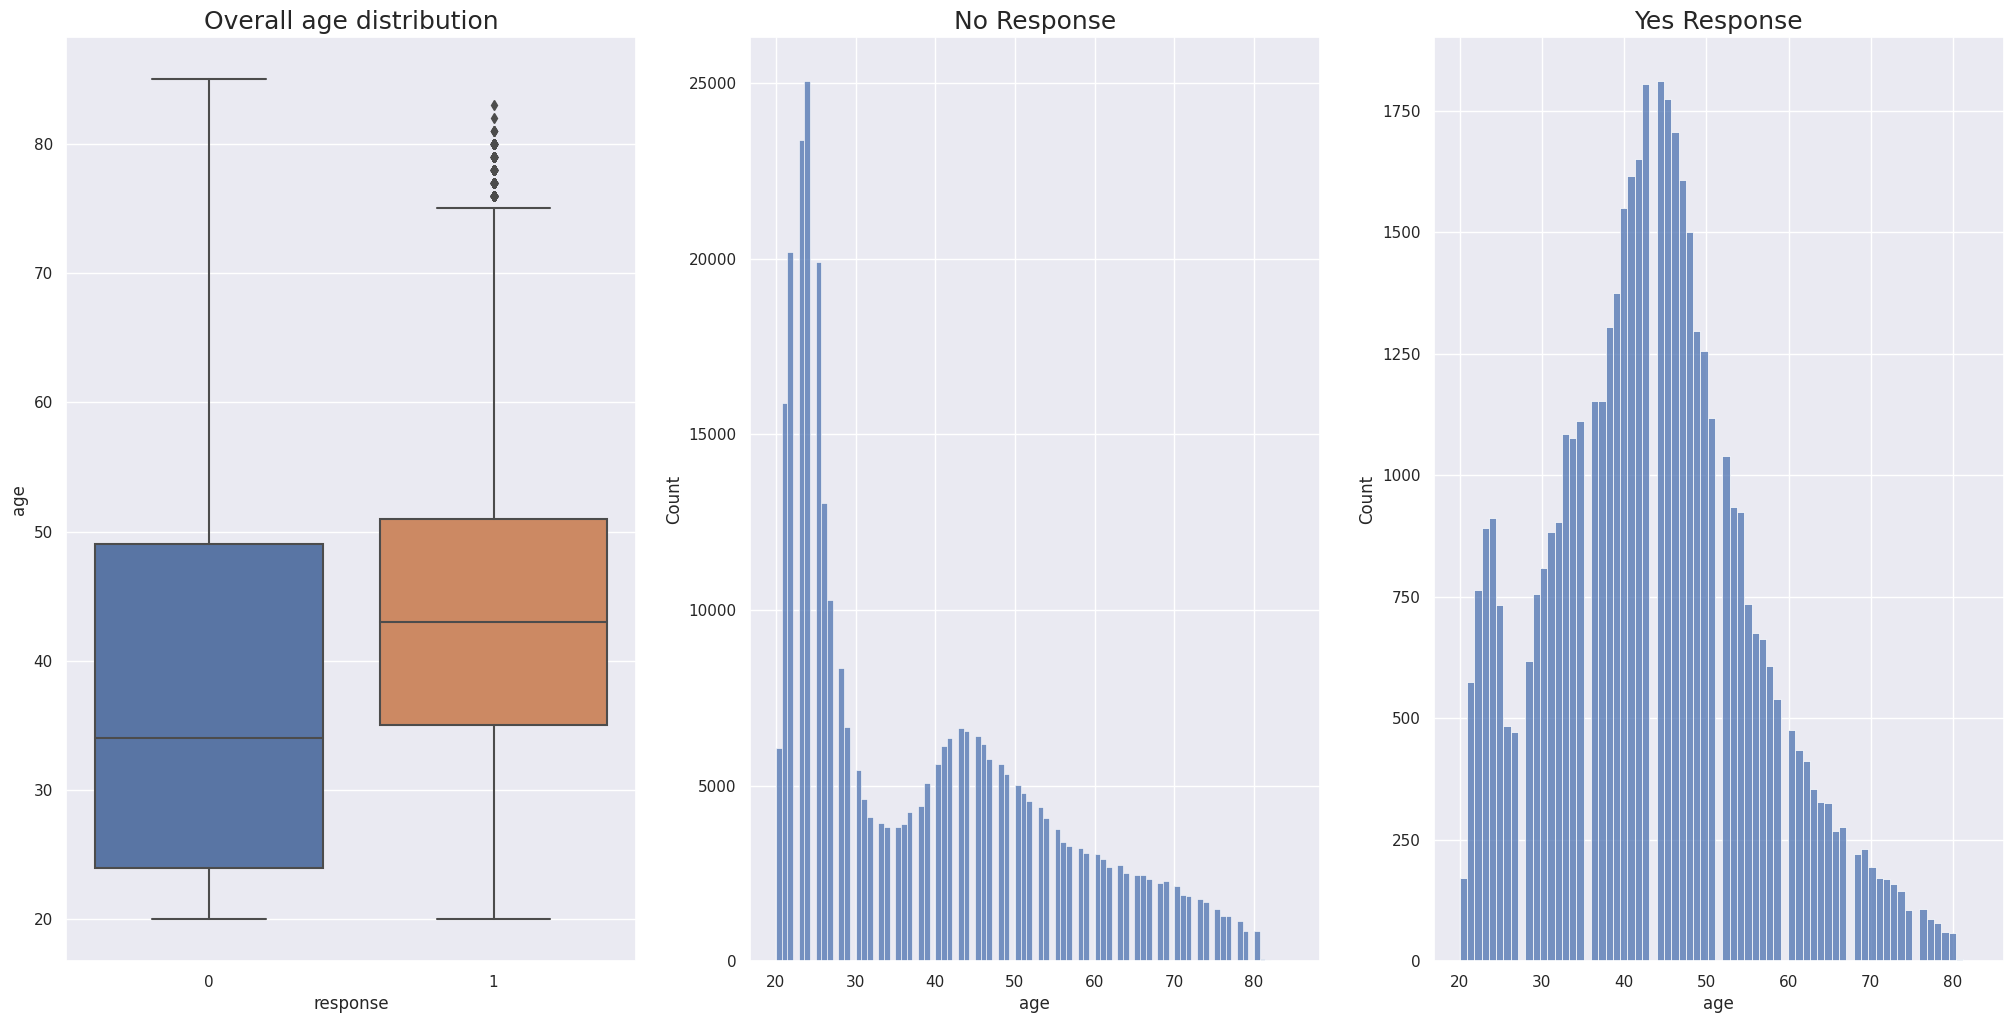

In [25]:
plt.subplot(1,3,1)
plt.title ('Overall age distribution', fontsize=18)
sns.boxplot(df3, x='response', y='age');

plt.subplot(1,3,2)
plt.title('No Response',fontsize=18)
aux = df3.loc[df3['response'] == 0, :]
sns.histplot(aux, x='age');

plt.subplot(1,3,3)
plt.title('Yes Response', fontsize=18)
aux = df3.loc[df3['response'] == 1, :]
sns.histplot(aux, x='age');

### H.2 Clients who already have a vehicle insurance are 10% less likely to aquire a new insurance plan.

**True** -> CAUTION: The severe unbalanced proportion shown on the contigency table between 'previously_insured' and 'response' variable can be a sign of data leakage; hence it will not be adequate for use upon building our Machine Learning model.

In [26]:
aux2 = pd.crosstab(df3['previously_insured'], df3['response'])
aux2 = aux2.apply(lambda x: x/x.sum(), axis=1)
aux2

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### H.3 Clients with higher annual premium paid are 10% less likely to acquire a vehicular insurance.
**False** -> Both distributions point to similar mean and median values. (Similiar central tendency metrics)

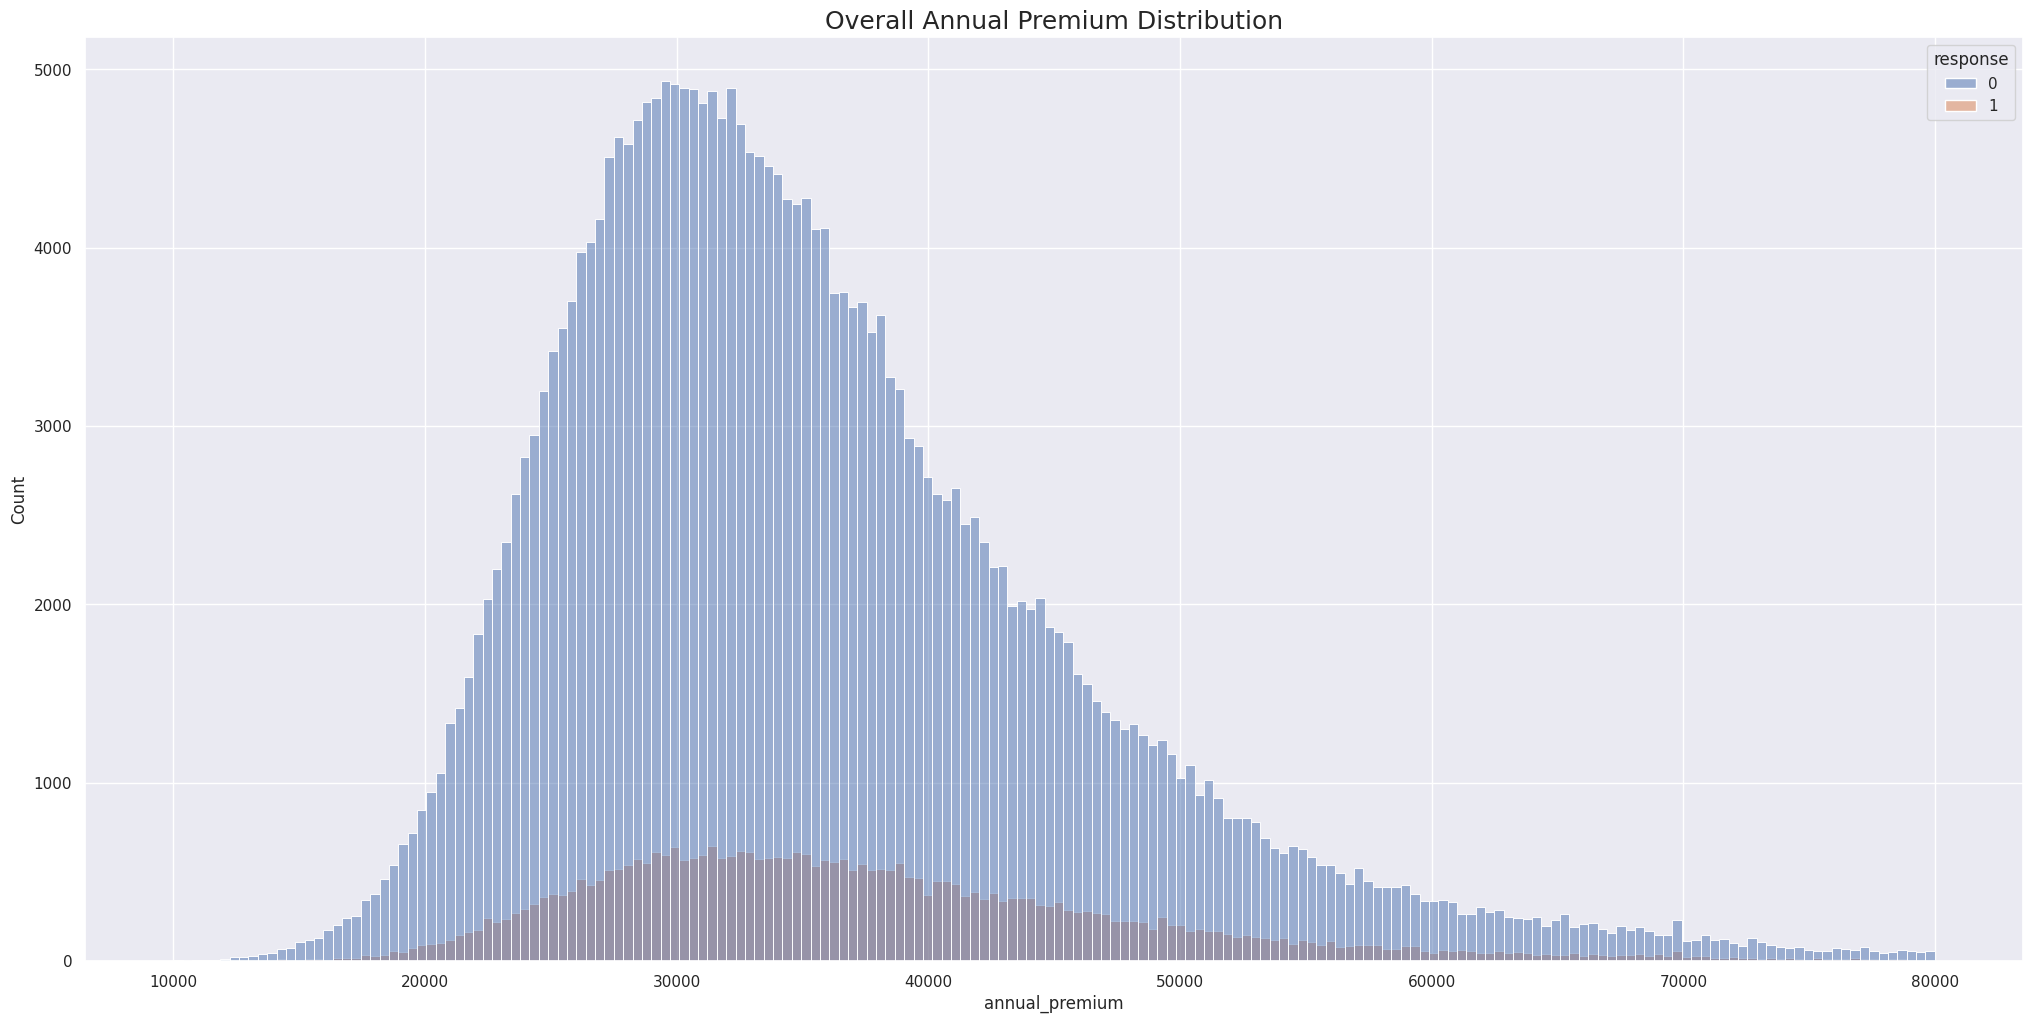

In [27]:
plt.title('Overall Annual Premium Distribution', fontsize=18)
aux3 = df3.loc[ (df3['annual_premium'] > 10000) & (df3['annual_premium'] < 80000), :]
sns.histplot(aux3, x='annual_premium', hue='response');

In [28]:
#Nota-se que há uma contagem muito grande (ordem de 65k de entradas) com annual premium padronizado no valor de $2630,00
    #possívelmente o 'plano básico/padrão' da seguradora de saúde

out1 = df3[['annual_premium','response']].groupby('annual_premium').count().sort_values('response',ascending=False).reset_index()
out1.head()

,annual_premium,response
0,2630.0,64877
1,69856.0,140
2,39008.0,41
3,38287.0,38
4,45179.0,38




*   It is important to note that there is a very large count for entries with 'annual_premium' with a fixated value of $2630,00. This is possibly due to a 'standard/default plan' offered by the Health Insurance Company



### H.4 Older clients on the database (Higher vintage count) are 10% more likely to acquire a vehicular insurance..
**False** -> No Significant difference observed while relating 'vintage x response' variables.

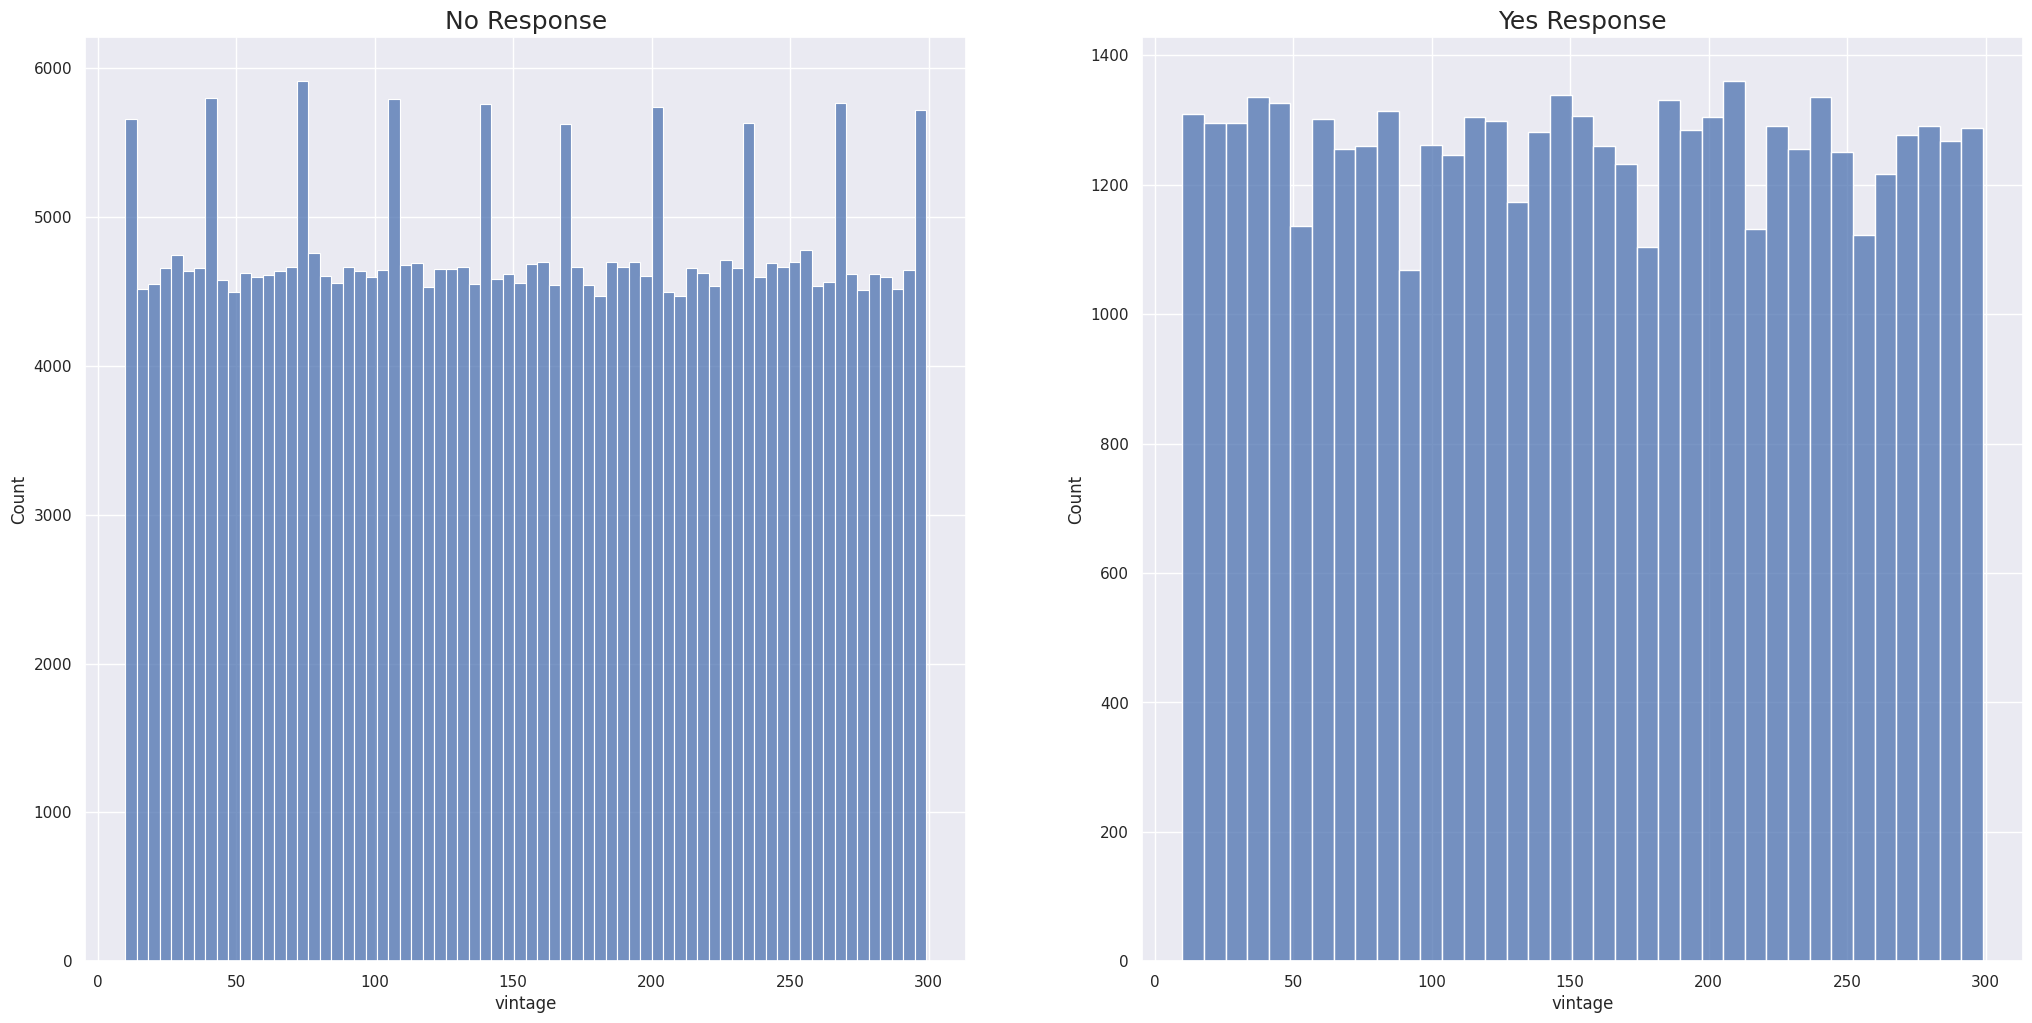

In [29]:
plt.subplot(1,2,1)
plt.title('No Response', fontsize=18)
aux4 = df3.loc[df3['response'] == 0, :]
sns.histplot(aux4, x='vintage');

plt.subplot(1,2,2)
plt.title('Yes Response', fontsize=18)
aux4 = df3.loc[df3['response'] == 1, :]
sns.histplot(aux4, x='vintage');

### H.5 Clients with valid drivers license are 10% more likely to acquire a new vehicular insurance.
**False** -> Although there is a higher proportion (shown as percentages on the contingency table) of interest shown by those who have valid drivers licenses, it is only 7% higher than of those who have not.

In [30]:
aux5 = pd.crosstab(df3['driving_license'], df3['response'])
aux5 = aux5.apply(lambda x: x/x.sum(), axis=1)
aux5

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### H.6 Clients with older vehicles are 10% more likely to acquire a vehicular insurance.
**True** -> Those who have older cars (Older than 2 years) present a higher percentual proportion for interest in acquiring vehicular insurance compared to the other 'vehicle_age' classes.

In [31]:
df3[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


In [32]:
#Vehicle age score atribution
vehicle_age_dict = {'< 1 Year': 1,
                    '1-2 Year': 2,
                    '> 2 Years': 3}
df3['vehicle_age_score'] = df3['vehicle_age'].map(vehicle_age_dict)

### H.7 Clients whose vehicles were already damaged are 10% more likely to acquire a vehicle insurance.
**True** -> There is a higher percentual proportion for people interested in acquiring vehicular insurance amongst those who had their vehicle damaged at some point.

In [33]:
aux7 = pd.crosstab(df3['vehicle_damage'], df3['response']).apply(lambda x: x/x.sum(), axis = 1)
aux7

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### H.8 Clientes de determinada região são mais propensos a adquirir um plano de seguro veícular.
**Falso** -> Proporcionalmente, não há uma região específica onde o interesse de compra se destaque

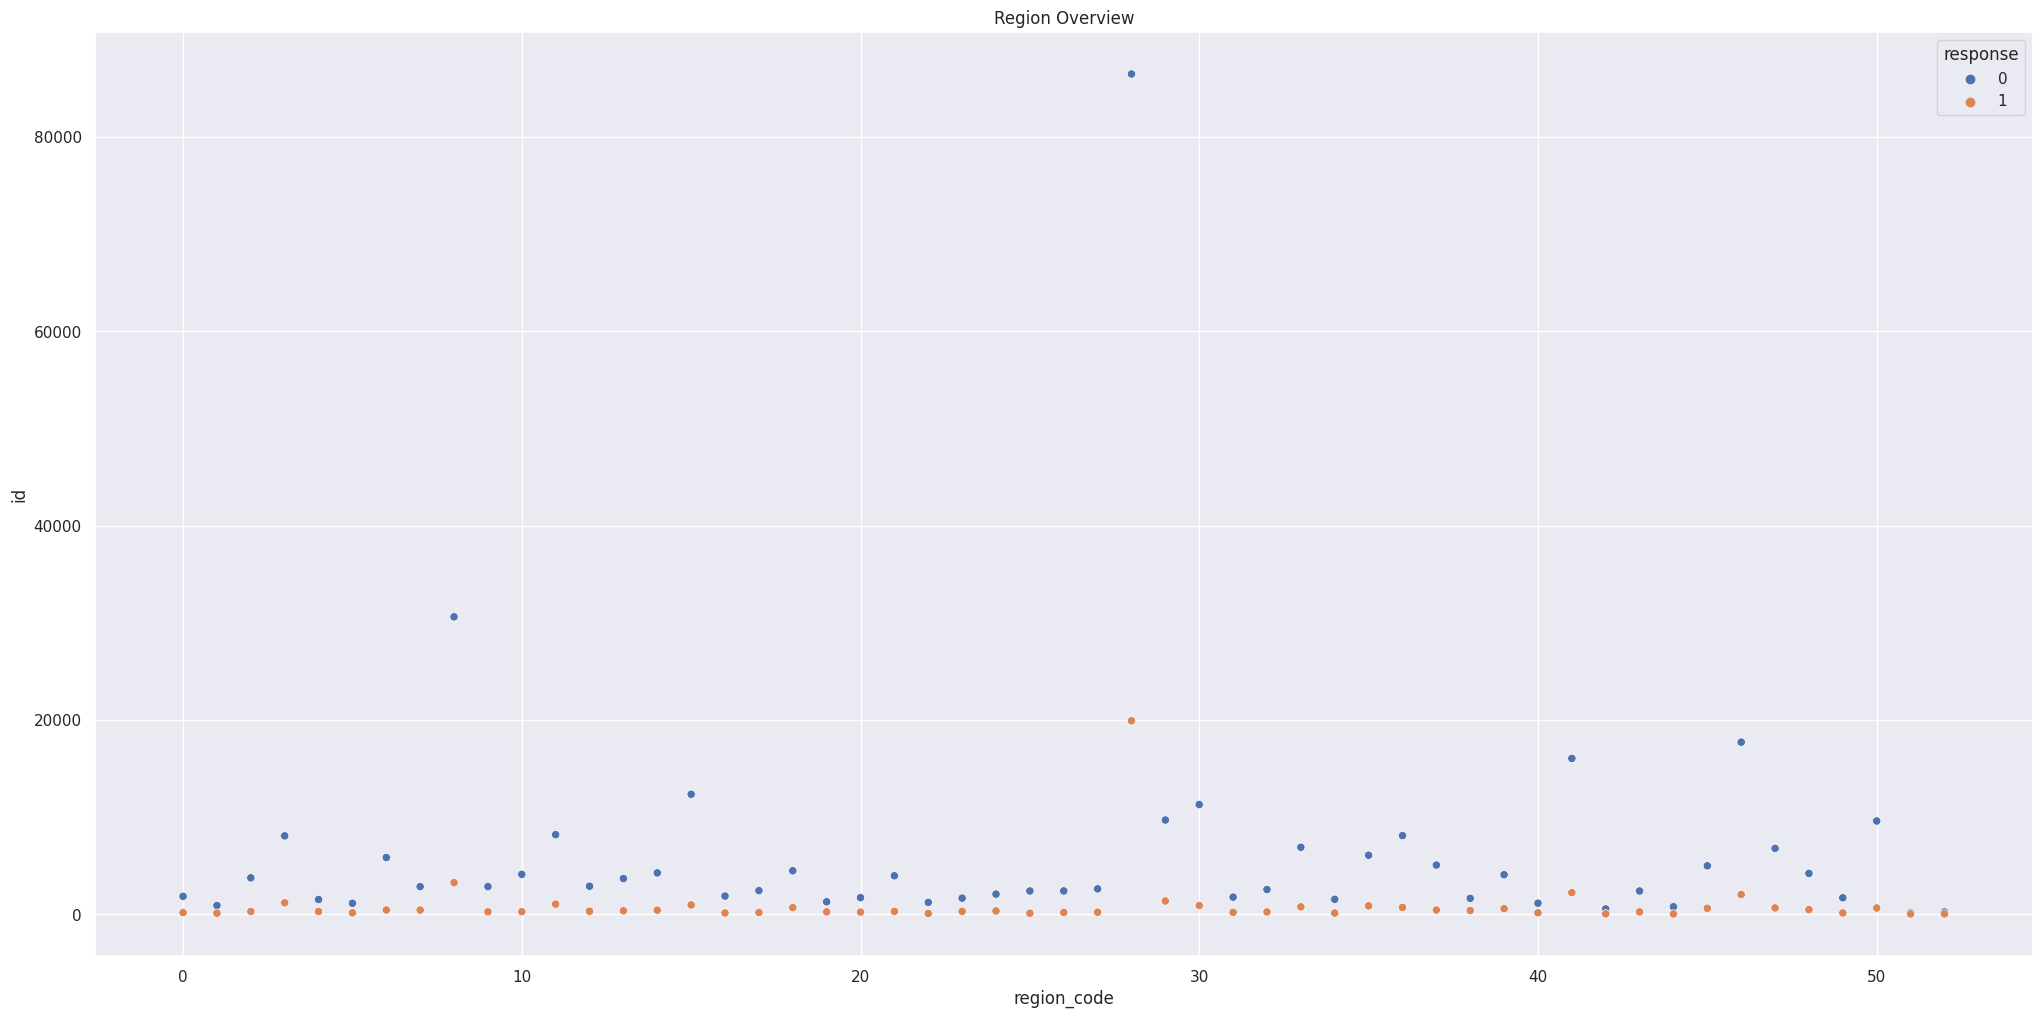

In [34]:
plt.title('Region Overview')
aux8 = df3[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(aux8, x='region_code', y='id', hue='response');

### H.9 Clients of a particular region are 10% more likely to acquire vehicular insurance.
**True** -> Some region code present much larger proportion of interested people in acquiring vehicular insurance, as shown on the stacked bar graph below.

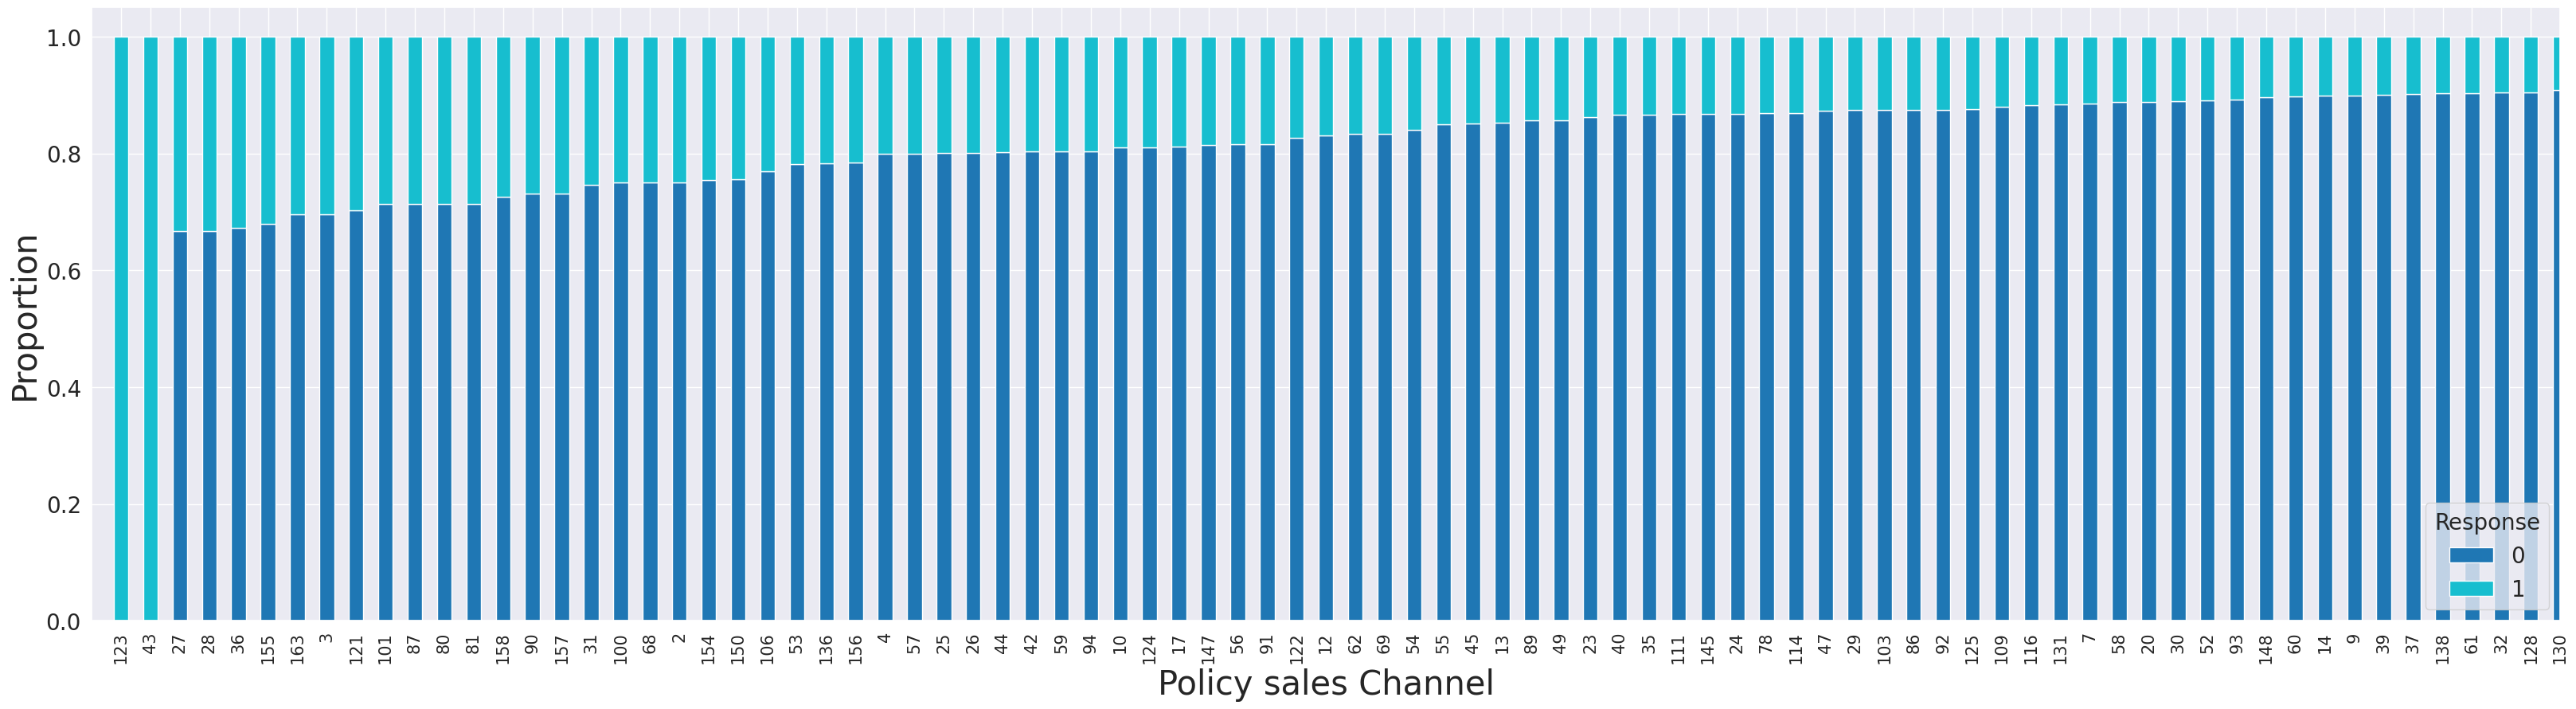

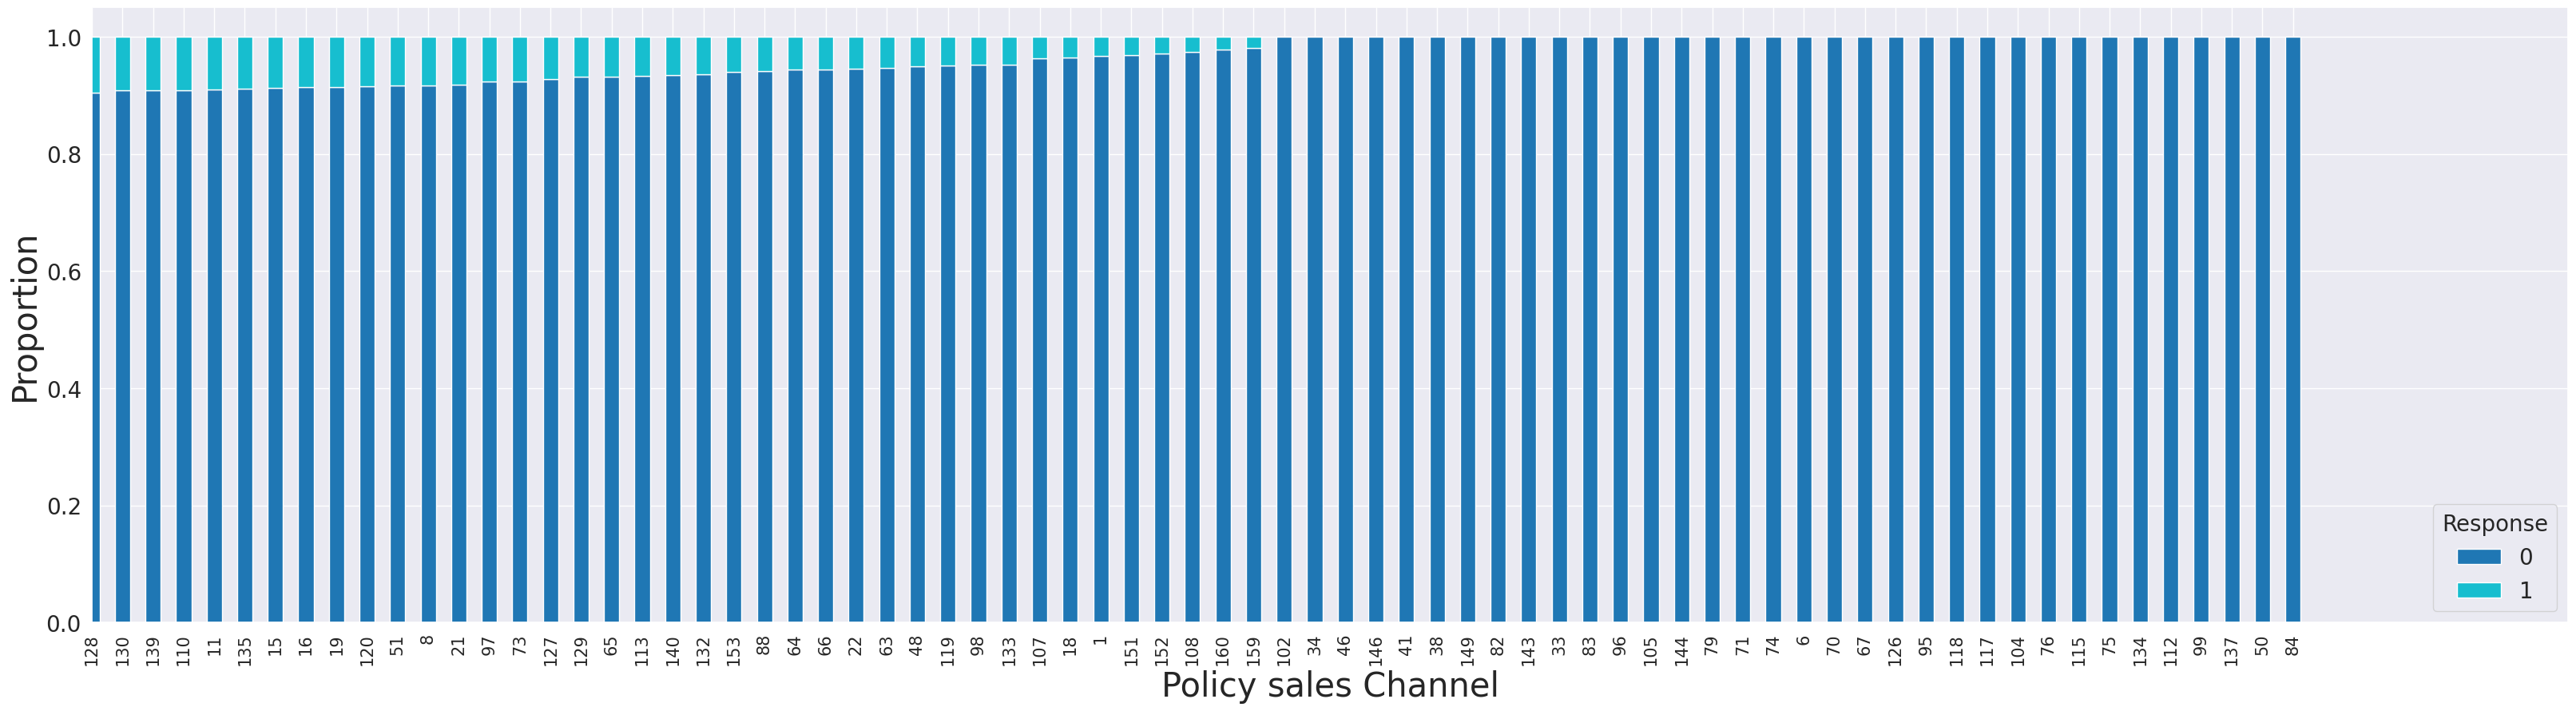

In [35]:
aux9 = pd.crosstab(df3['policy_sales_channel'], df3['response']).apply(lambda x: x/x.sum(), axis = 1).sort_values(1, ascending=False)

ax1 = aux9.plot(kind='bar',
          stacked=True,
          colormap='tab10',
          figsize = (40, 10));
plt.xlabel('Policy sales Channel',fontsize=30);
plt.xticks(fontsize=15);
plt.xlim(-1, 83);
plt.ylabel('Proportion', fontsize = 30);
plt.yticks(fontsize=20);

ax1.legend(loc='lower right', prop={'size': 20}, title_fontsize= 20, title= 'Response');

ax2 = aux9.plot(kind='bar',
          stacked=True,
          colormap='tab10',
          figsize = (40, 10));
plt.xlabel('Policy sales Channel',fontsize=30);
plt.xticks(fontsize=15);
plt.xlim(82, 163);
plt.ylabel('Proportion', fontsize = 30);
plt.yticks(fontsize=20);

ax2.legend(loc='lower right', prop={'size': 20}, title_fontsize= 20, title= 'Response');

### 3.2.2 EDA's Summary

In [36]:
from tabulate import tabulate

In [37]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'True', 'Low'], #Possible Data Leakage: Lack of Interested if those who already have vehicular insurance in acquiring a new one.
       ['H3', 'False', 'Low'],
       ['H4', 'False', 'Low'],
       ['H5', 'False', 'Low'],
       ['H6', 'True', 'High'],  #Proportionaly, almost half of those who have cars over 2 years of age showed interest in acquiring vehicular insurance
       ['H7', 'True', 'High'],  #There is more than 10% diference amongst the total of interested people who had damaged vehicles compared to non-damaged ones.
       ['H8', 'False', 'Low'],
       ['H9', 'True', 'High']] #Some region codes show a much larger proportion of interested people.

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            True          Low
H3            False         Low
H4            False         Low
H5            False         Low
H6            True          High
H7            True          High
H8            False         Low
H9            True          High


### 3.2.3 Feature Engineering (Bivariate Features)



*   The following features were created in order to further study patterns regarding features that had shown little relevance on EDA. This was done by combining 'annual_premium' and 'vintage' feature to other variables.



In [38]:
#annual premium paid per day
df3['annual_premium_per_day'] = df3['annual_premium']/df3['vintage']

#annual premium divided per client age
df3['annual_premium_per_age'] = df3['annual_premium']/df3['age']

#vintage_per_age
df3['vintage_per_age'] = df3['vintage']/df3['age']



*   The following features were created by establishing a score to both 'scored_sales_channel' and 'region_code' entries which had larger proportion of interested people with interest to acquire vehicular insurance



In [39]:
#Creation of the dictionary that will designate each policy sales channel to its score
aux9_2 = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').value_counts(normalize=True).reset_index()
aux9_2 = aux9_2.drop(aux9_2[aux9_2['response'] == 0].index).sort_values(0)
aux9_2['scored_sales_channel'] = aux9_2[0].apply(lambda x: 5 if x > 0.3 else
                                                 4 if (x <= 0.3) & (x > 0.25) else
                                                 3 if (x <= 0.25) & (x > 0.2) else
                                                 2 if (x <= 0.2) & (x > 0.1) else 1)
scored_sales_channel = {channel: score for channel, score in zip(aux9_2['policy_sales_channel'], aux9_2['scored_sales_channel'])}

#Appending the scored channel to the original dataframe, on its respective ids
df3['scored_sales_channel'] = df3['policy_sales_channel'].map(scored_sales_channel)
df3['scored_sales_channel'].fillna(1, inplace=True)
df3['scored_sales_channel']= df3['scored_sales_channel'].astype(np.int64)

In [40]:
#Creation of the dictionary that will designate each region code to its score
aux8_2 = df3[['region_code', 'vehicle_damage', 'response']].groupby('region_code').value_counts(normalize=True).reset_index()
aux8_2 = aux8_2.loc[(aux8_2['response'] == 1) & (aux8_2['vehicle_damage'] == 1), :].sort_values(0)
aux8_2['region_score'] = aux8_2[0].apply(lambda x: 4 if x >= 0.15 else
                                        3 if (x < 0.15) & (x >= 0.10) else
                                        2 if (x < 0.10) & (x >= 0.05) else 1)
region_insured_dict = {region: score for region, score in zip(aux8_2['region_code'], aux8_2['region_score'])}

#Appending the scored regions to the original dataframe, on its respective ids
df3['region_score'] = df3['region_code'].map(region_insured_dict)
df3['region_score'].fillna(1, inplace=True)
df3['region_score'] = df3['region_score'].astype(np.int64)

## 3.3 Multivariative Analysis

In [41]:
df3.dtypes

id                          int64
age                         int64
region_code                 int64
policy_sales_channel        int64
previously_insured          int64
annual_premium            float64
vintage                     int64
driving_license             int64
vehicle_age                object
vehicle_damage              int64
response                    int64
vehicle_age_score           int64
annual_premium_per_day    float64
annual_premium_per_age    float64
vintage_per_age           float64
scored_sales_channel        int64
region_score                int64
dtype: object

In [42]:
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'scored_sales_channel', 'vehicle_age_score', 'region_score',
       'annual_premium_per_day', 'annual_premium_per_age',
       'vintage_per_age', 'response']

df3 = df3.reindex(columns=reorder_columns)

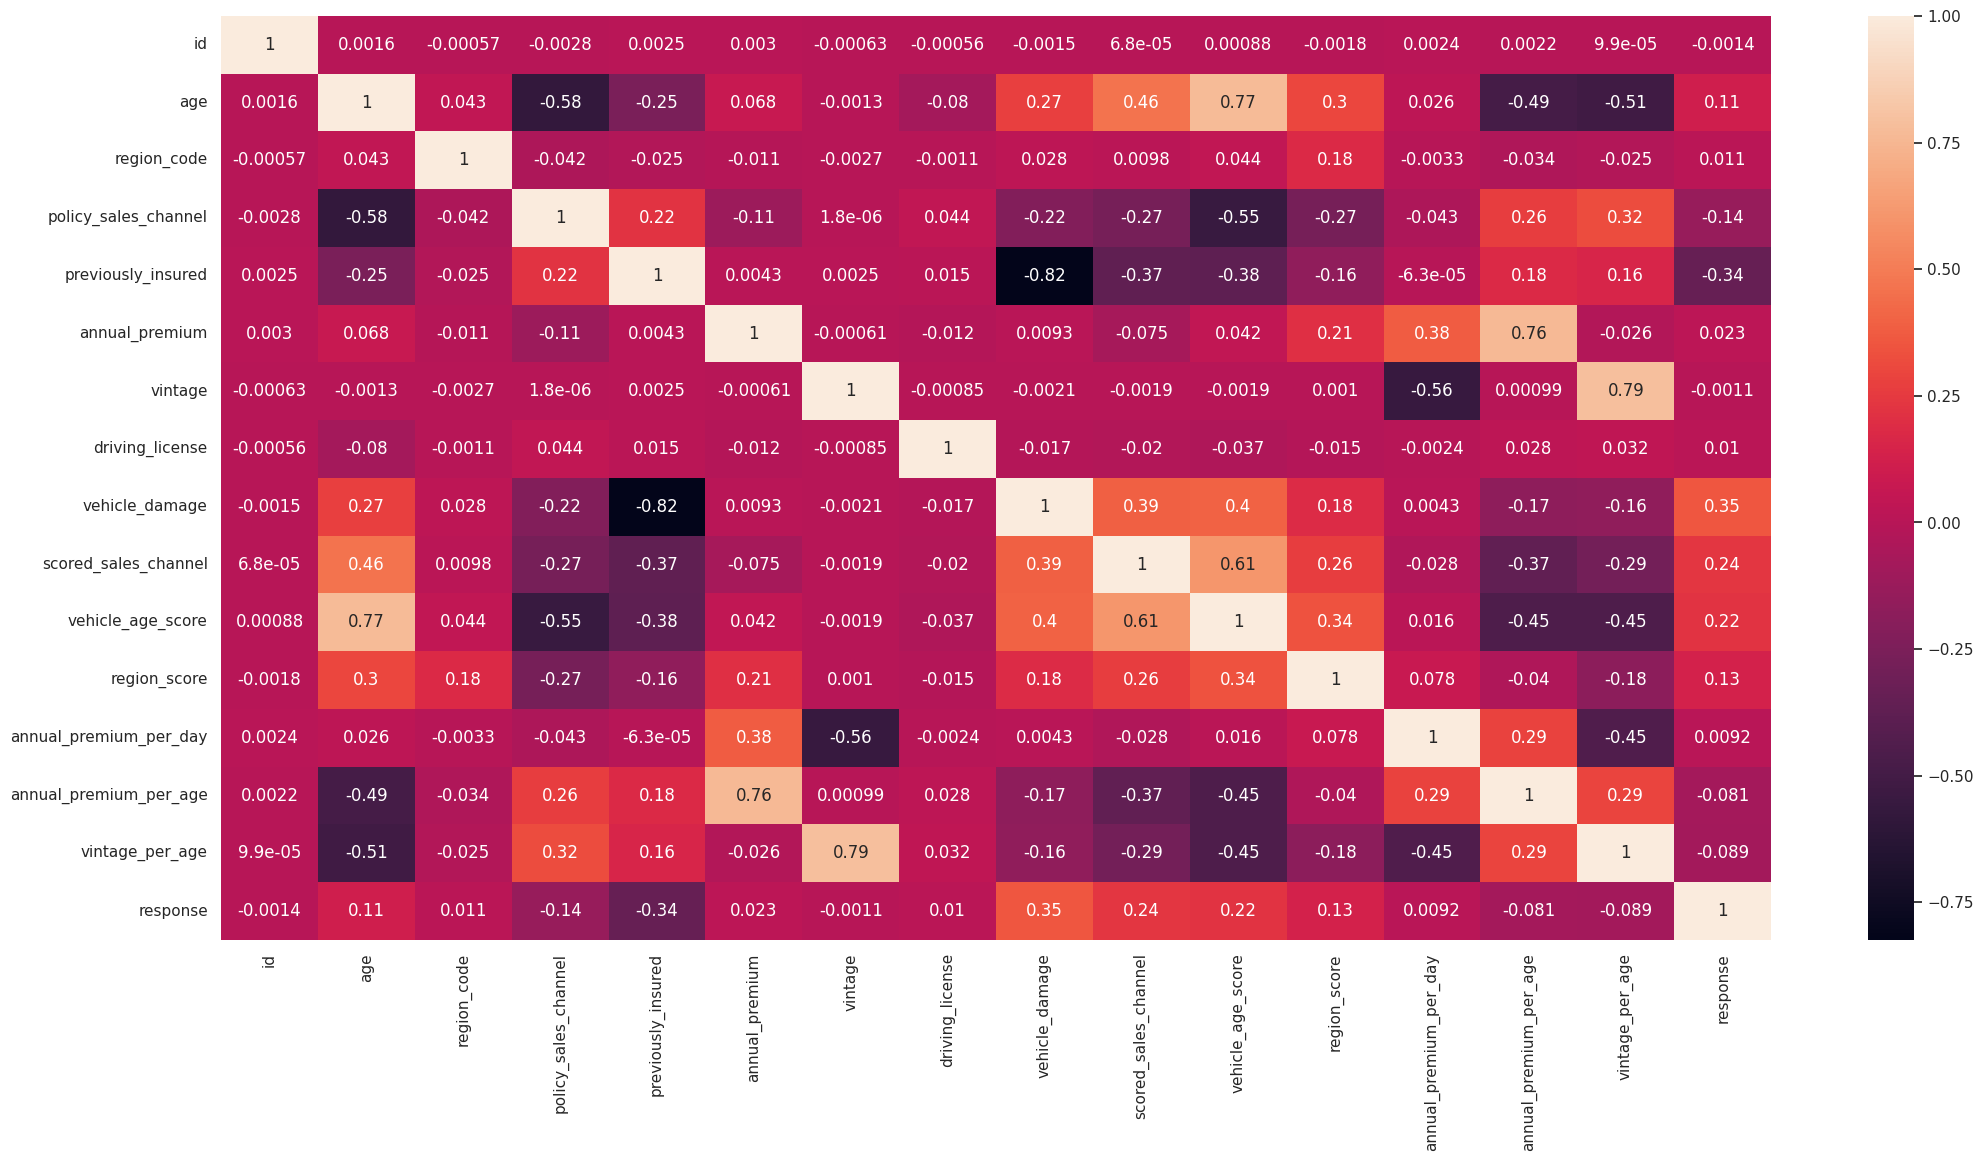

In [43]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])
correlation = df3_num.corr(method='pearson')
sns.heatmap(correlation, annot=True);



*   By Multivariative analysis, we can conclude that the features that involved scoring presented better correlation to our class variable (response).
*   The same **cannot** be said about the other bivariate features .



# 4.0 DATA PREPARATION

In [44]:
df4 = df3.copy()

In [45]:
df4.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,annual_premium_per_day,annual_premium_per_age,vintage_per_age,response
0,7,23,11,152,0,23367.0,249,1,< 1 Year,1,1,1,3,93.843373,1015.956522,10.826087,0
1,13,41,15,14,1,31409.0,221,1,1-2 Year,0,2,2,2,142.122172,766.073171,5.390244,0
2,18,25,35,152,1,46622.0,299,1,< 1 Year,0,1,1,3,155.926421,1864.880000,11.960000,0
3,31,26,8,160,0,2630.0,136,1,< 1 Year,0,1,1,2,19.338235,101.153846,5.230769,0
4,39,45,8,124,0,42297.0,264,1,1-2 Year,1,2,2,2,160.215909,939.933333,5.866667,0


In [46]:
x_split = df4.drop('response', axis=1)
y_split = df4['response'].copy()

X_train, X_validation , y_train, y_validation = train_test_split(x_split, y_split, test_size=0.2, random_state=32)

df4 = pd.concat([X_train, y_train], axis=1)

## 4.1 Standardization

In [47]:
ss_premium = StandardScaler()
ss_premium_day = StandardScaler()
ss_premium_age = StandardScaler()

#annual_premium
df4['annual_premium'] = ss_premium.fit_transform(df4[['annual_premium']].values)
#pickle.dump(ss_premium, open('/home/valquiriaam/repos/PA004/src/features/ss_premium_scaler.pkl', 'wb'))

#annual_premium_per_day
df4['annual_premium_per_day'] = ss_premium_day.fit_transform(df4[['annual_premium_per_day']].values)
#pickle.dump(ss_premium_day, open('/home/valquiriaam/repos/PA004/src/features/ss_premium_day_scaler.pkl', 'wb'))

#annual_premium_per_age
df4['annual_premium_per_age'] = ss_premium_age.fit_transform(df4[['annual_premium_per_age']].values)
#pickle.dump(ss_premium_age, open('/home/valquiriaam/repos/PA004/src/features/ss_premium_age_scaler.pkl', 'wb'))

## 4.2 Reescaling

In [48]:
#Analyze the occurance of outliers for further reescale method
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()
mms_vintage_age = MinMaxScaler()

#age
df4['age'] = mms_age.fit_transform(df4[['age']].values)
#pickle.dump(mms_age, open('/home/valquiriaam/repos/PA004/src/features/mms_age_scaler.pkl', 'wb'))

#vintage
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)
#pickle.dump(mms_vintage, open('/home/valquiriaam/repos/PA004/src/features/mms_vintage_scaler.pkl', 'wb'))

#vintage_per_age
df4['vintage_per_age'] = mms_vintage_age.fit_transform(df4[['vintage_per_age']].values)
#pickle.dump(mms_vintage_age, open('/home/valquiriaam/repos/PA004/src/features/mms_vintage_age_scaler.pkl', 'wb'))

## 4.3 Data Transformation (Encoding)

In [49]:
#region_code - Frequency Encoding
fe_region = df4.groupby('region_code').size()/len(df4)
df4.loc[:, 'region_code'] = df4['region_code'].map(fe_region)
#pickle.dump(fe_region, open('/home/valquiriaam/repos/PA004/src/features/fe_region_scaler.pkl', 'wb'))

#policy_sales_channel - Mean Target Encoding
te_channel = df4.groupby('policy_sales_channel')['response'].mean()
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(te_channel)
#pickle.dump(te_channel, open('/home/valquiriaam/repos/PA004/src/features/te_channel_scaler.pkl', 'wb'))

#NOTA -> For Vehicle Age, the created feature 'vehicle_age_score' was maintained, given that it functions as an ordinal encoder for 'vehicle_age'.
#vehicle_age - One Hot Encoding
#df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])



## 4.4 Validation Data Preparation

In [50]:
#age
X_validation.loc[:, 'age'] = mms_age.transform(X_validation[['age']].values)

#region_code
X_validation.loc[:, 'region_code'] = X_validation.loc[:, 'region_code'].map(fe_region)

#policy_sales_channel
X_validation.loc[:, 'policy_sales_channel'] = X_validation.loc[:, 'policy_sales_channel'].map(te_channel)

#annual_premium
X_validation.loc[:, 'annual_premium'] = ss_premium.transform(X_validation[['annual_premium']].values)

#vintage
X_validation.loc[:, 'vintage'] = mms_vintage.transform(X_validation[['vintage']].values)

#vehicle_age
X_validation.loc[:, 'vehicle_age'] = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

#annual_premium_per_day
X_validation.loc[:, 'annual_premium_per_day'] = ss_premium_day.transform(X_validation[['annual_premium_per_day']].values)

#annual_premium_per_age
X_validation.loc[:, 'annual_premium_per_age'] = ss_premium_age.transform(X_validation[['annual_premium_per_age']].values)

#vintage_per_age
X_validation.loc[:, 'vintage_per_age'] = mms_vintage_age.transform(X_validation[['vintage_per_age']].values)

##fillna
X_validation = X_validation.fillna(0)


# 5.0 FEATURE SELECTION

In [51]:
df5 = df4.copy()

## 5.1 Train-Test Split

In [52]:
training_data, testing_data = X_train, X_validation

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 304887
No. of testing examples: 76222


## 5.2 Feature Selection (w/ Random Forest)

In [53]:
X_train_n = df5.drop(['id', 'response' , 'vehicle_age'], axis=1)
y_train_n = y_train.values

#Define Random Forest Regressor
rf = BalancedRandomForestClassifier(n_estimators=250,
                                    max_depth=10,
                                    bootstrap=True,
                                    sampling_strategy=0.15,
                                    n_jobs=-1,
                                    random_state=32)
rf.fit(X_train_n, y_train_n)

BalancedRandomForestClassifier(max_depth=10, n_estimators=250, n_jobs=-1,
                               random_state=32, sampling_strategy=0.15)

Feature Ranking:
                  feature  importance
0          vehicle_damage    0.306705
0      previously_insured    0.271505
0    policy_sales_channel    0.109803
0                     age    0.086818
0    scored_sales_channel    0.082292
0       vehicle_age_score    0.039449
0  annual_premium_per_age    0.028006
0         vintage_per_age    0.015429
0             region_code    0.013659
0          annual_premium    0.012808
0            region_score    0.012077
0  annual_premium_per_day    0.011651
0                 vintage    0.009377
0         driving_license    0.000422


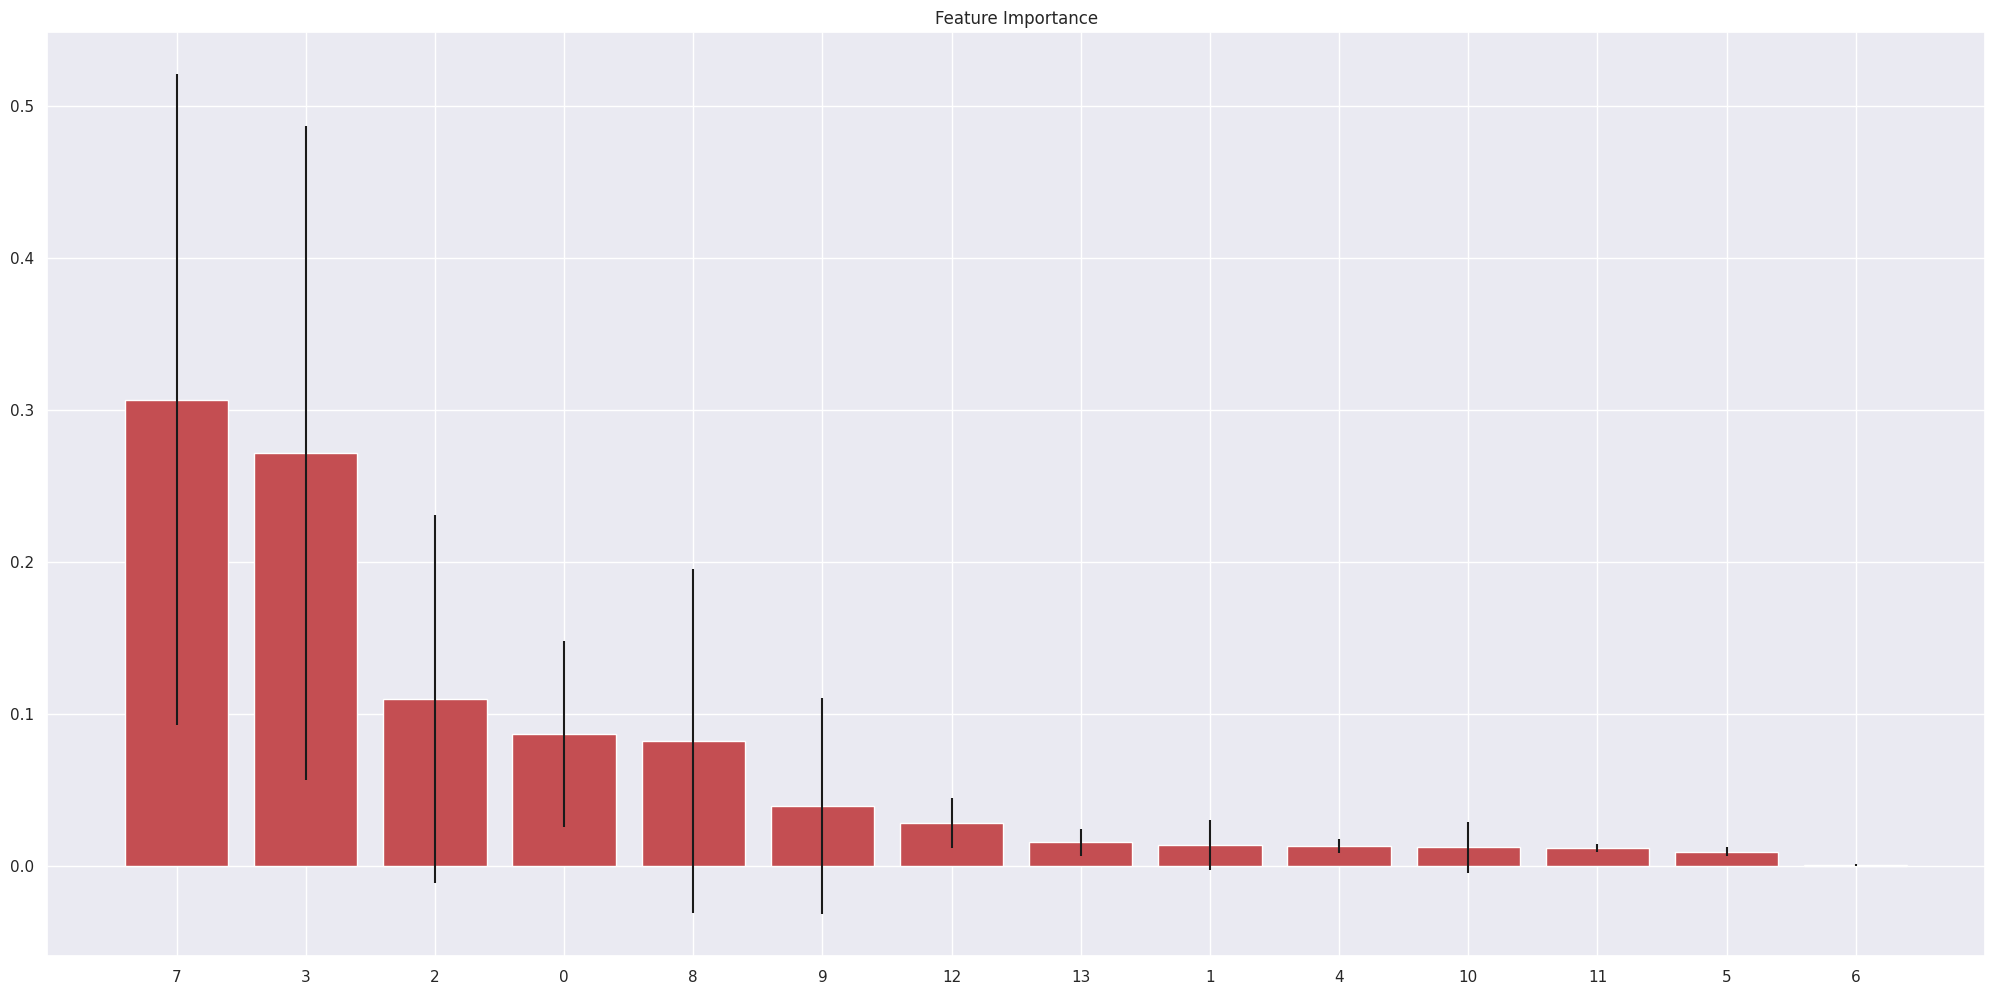

In [54]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print('Feature Ranking:')
df = pd.DataFrame()
for i, j in zip(X_train_n, rf.feature_importances_):
    aux_imp = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux_imp], axis=0)

print(df.sort_values('importance', ascending=False))

#Plot the impurity based feature importance target
plt.figure()
plt.title('Feature Importance')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks( range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

**Feature Selection Results**:



*   By EDA and Data Analysis: Age, vehicle_age, vehicle_damage, region_code, policy_sales_channel, scored_sales_channel, region_score, vehicle_age_score
*   By Balanced Random Forest: vehicle_damage, previously_insured, policy_sales_channel, age, scored_sales_channel, vehicle_age_score



# 6.0 Machine Learning



*  **IMPORTANT** -> The following Cross Validation procedures were executed by establishing the k-fold number as being 4, so that its test dataset matches the initial validation dataset in number of rows. This is done so because in order to compare 'recall@k' values, the size of a given dataset alters the analysis procedure for this metric, hence why it is needed to establish this base criteria.
*  Also note that all '@k' metrics were obtained by establishing its value
 as 'k=20000', such as our initial business problem requires.


In [55]:
df6 = df5.copy()

In [56]:
cols_selected = ['age', 'vehicle_age_score', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel', 'scored_sales_channel', 'region_score']

x_train = df6[ cols_selected ]
x_validation = X_validation[ cols_selected ]

## 6.1 Dummy/Baseline Model



*   The Dummy model shows the probability of randomly classifying a given entry as 1 or 0 as 50% for each class.



In [57]:
dummy = DummyClassifier()

#Model Training
dummy.fit(x_train, y_train)

#Model Prediction
yhat_dummy = dummy.predict_proba( x_validation )

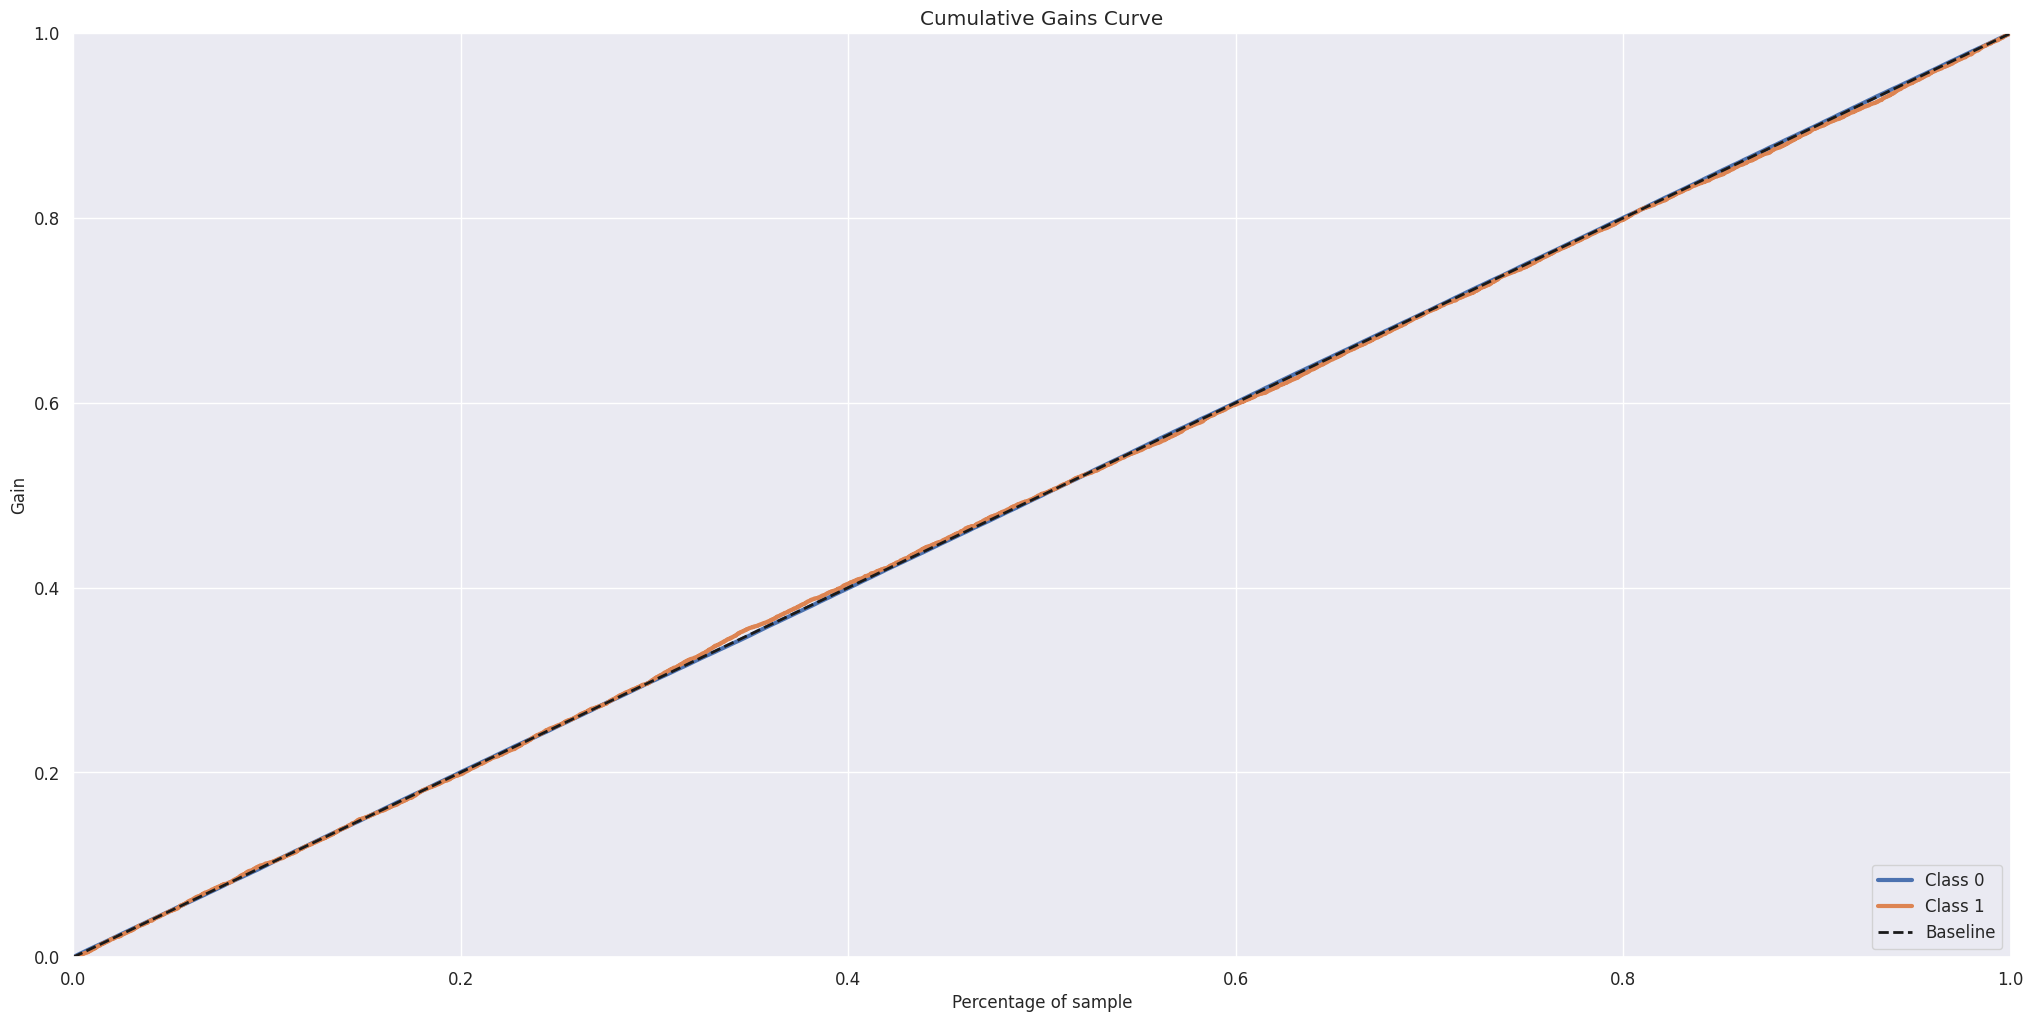

In [58]:
#Acumulative Gain Curve
skplt.metrics.plot_cumulative_gain( y_validation, yhat_dummy);

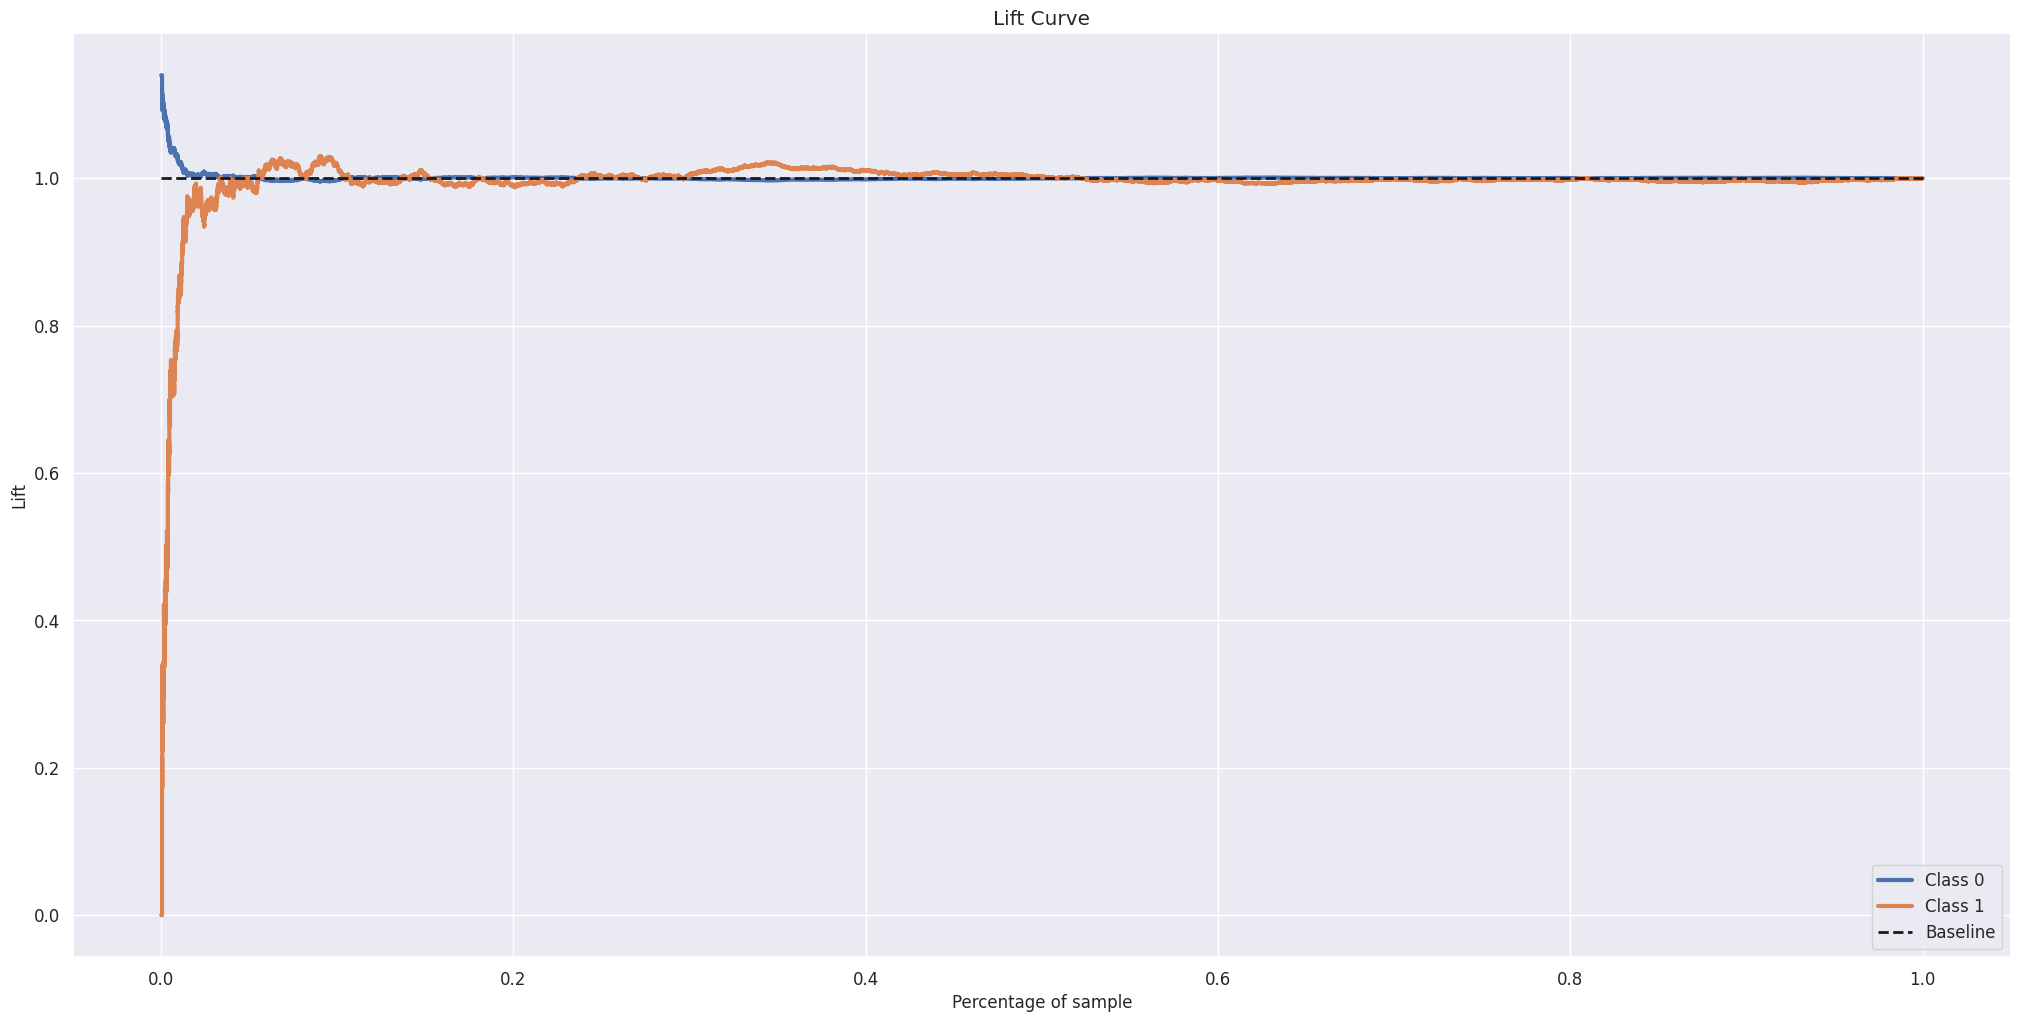

In [59]:
#Lift Gain Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_dummy);

In [60]:
dummy_score = ml_top_k_scores('Dummy', y_validation, yhat_dummy, 20000)
dummy_score

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.123,0.2633,0.1677


In [61]:
dummy_score_cv = ml_cv('Dummy Model', dummy, x_train, y_train)
dummy_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,Dummy Model,0.12 +/- 0.00127,0.27 +/- 0.00271,0.17 +/- 0.00173


## 6.2 KNN

In [62]:
knn = KNeighborsClassifier(n_neighbors=7)

#Model Training
knn.fit(x_train, y_train)

#Model Prediction
yhat_knn = knn.predict_proba( x_validation )

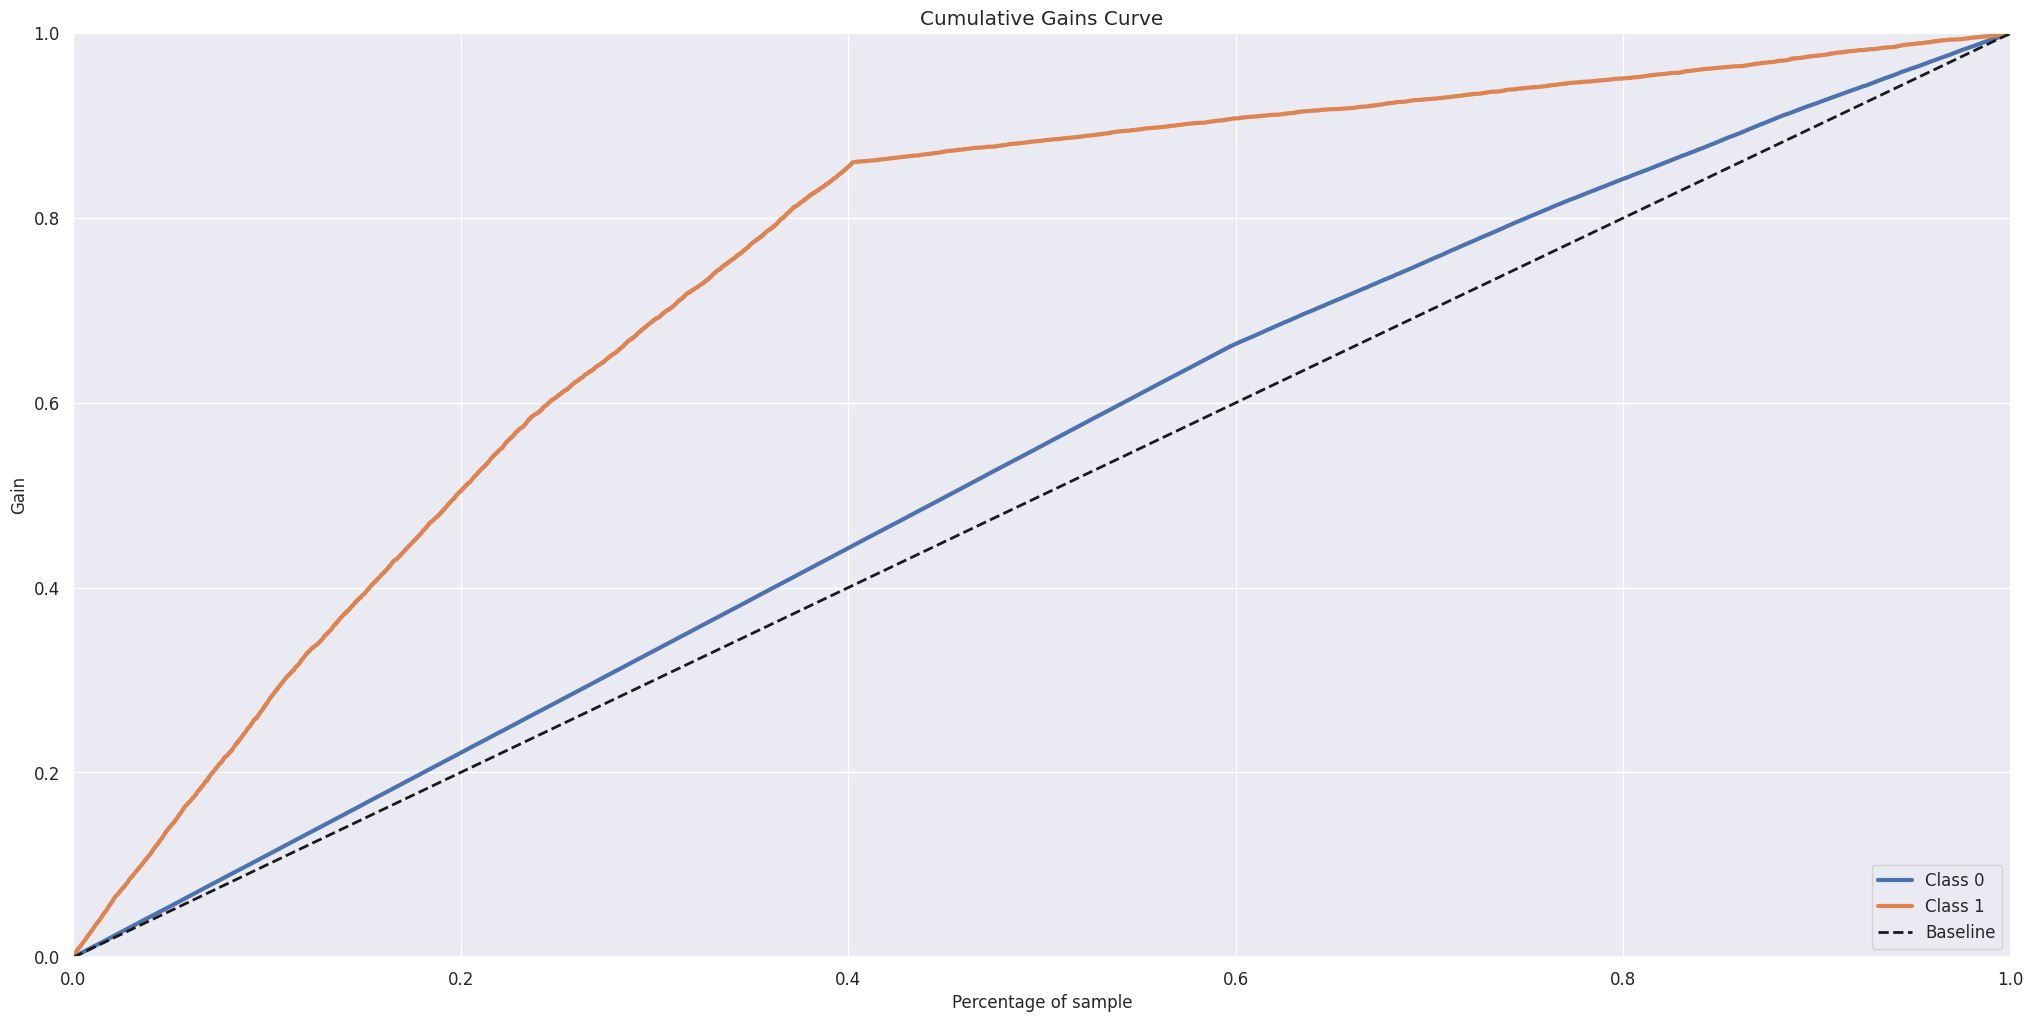

In [63]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn);

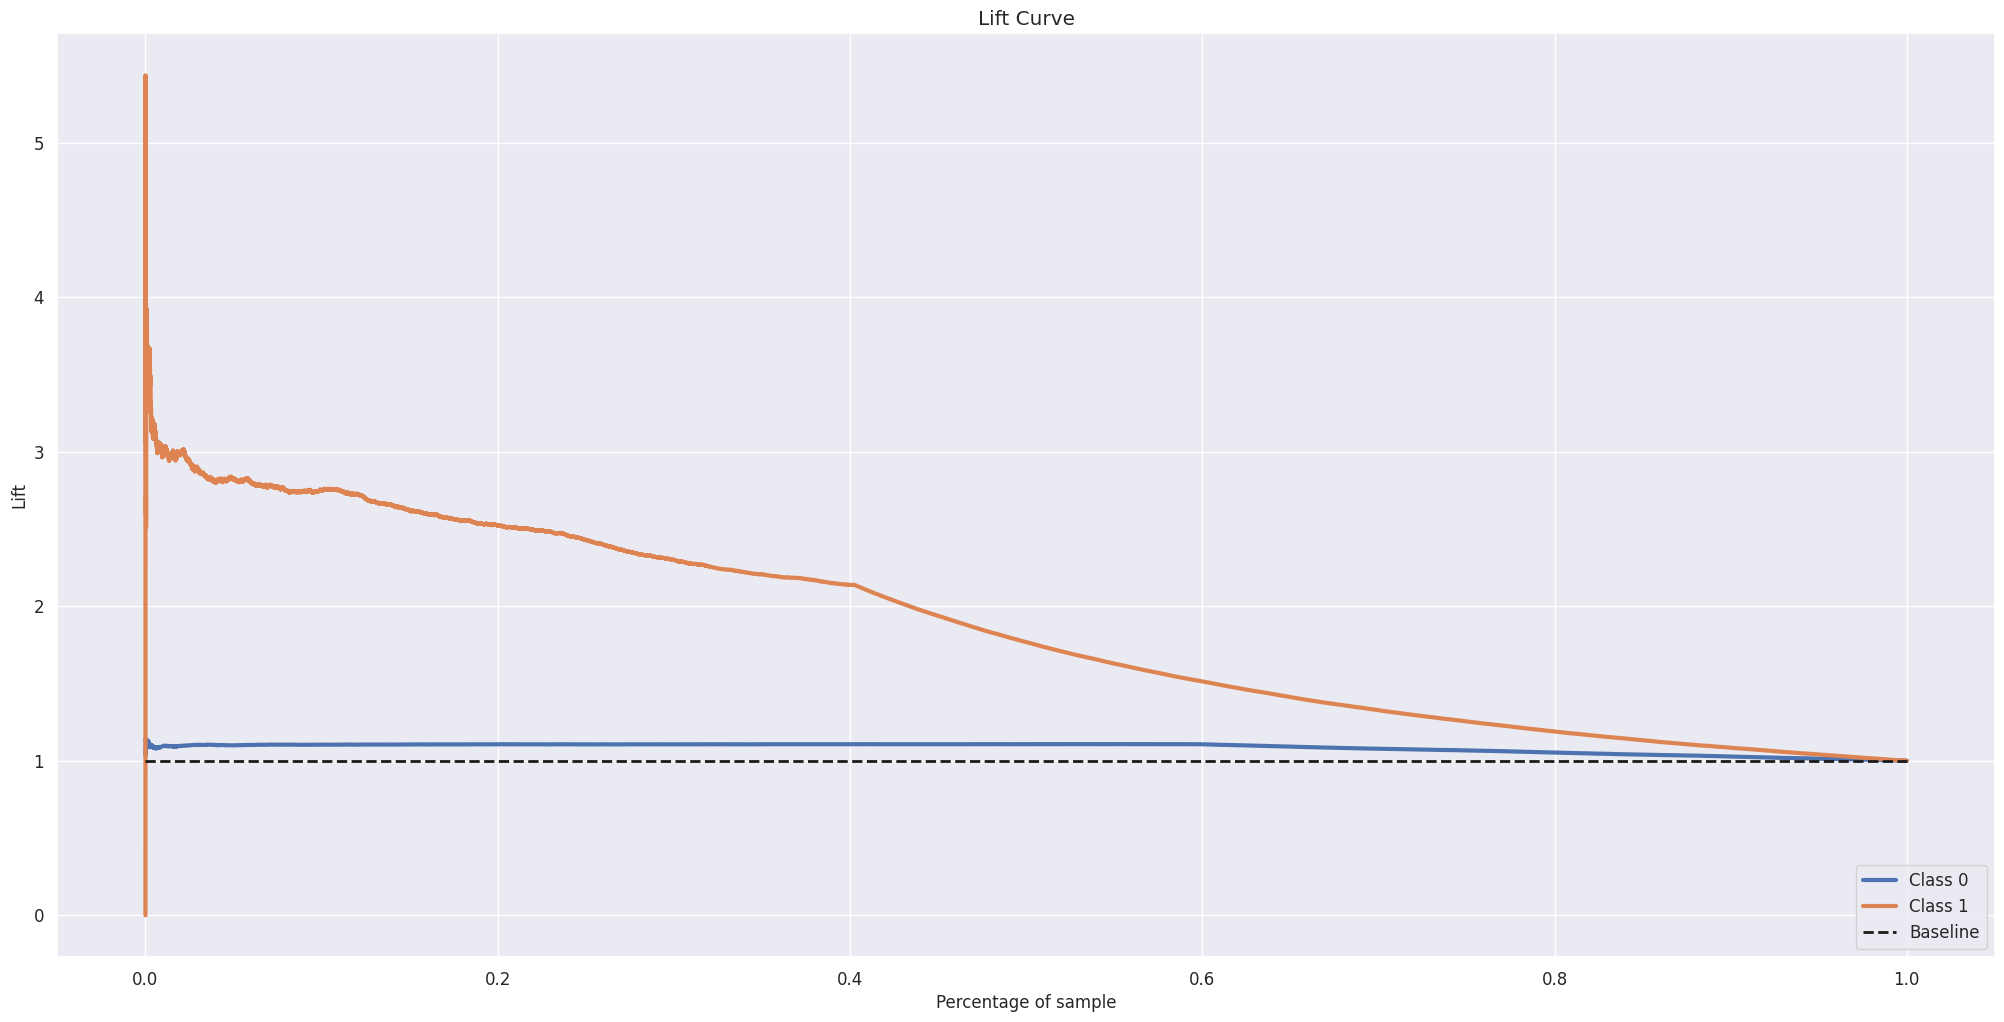

In [64]:
#Lift Curve Gain
skplt.metrics.plot_lift_curve(y_validation, yhat_knn);

In [65]:
knn_score = ml_top_k_scores('KNN Model', y_validation, yhat_knn, 20000)
knn_score

,Precision_at_k,Recall_at_k,F1_at_k
KNN Model,0.2933,0.6275,0.3997


In [66]:
knn_score_cv = ml_cv('KNN Model', knn, x_train, y_train)
knn_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,KNN Model,0.28 +/- 0.0033,0.59 +/- 0.00706,0.38 +/- 0.00449


## 6.3 Logistic Regression

In [67]:
lr = LogisticRegression( random_state=32 )

#Model Training
lr.fit (x_train, y_train)

#Prediction Model
yhat_lr = lr.predict_proba( x_validation )

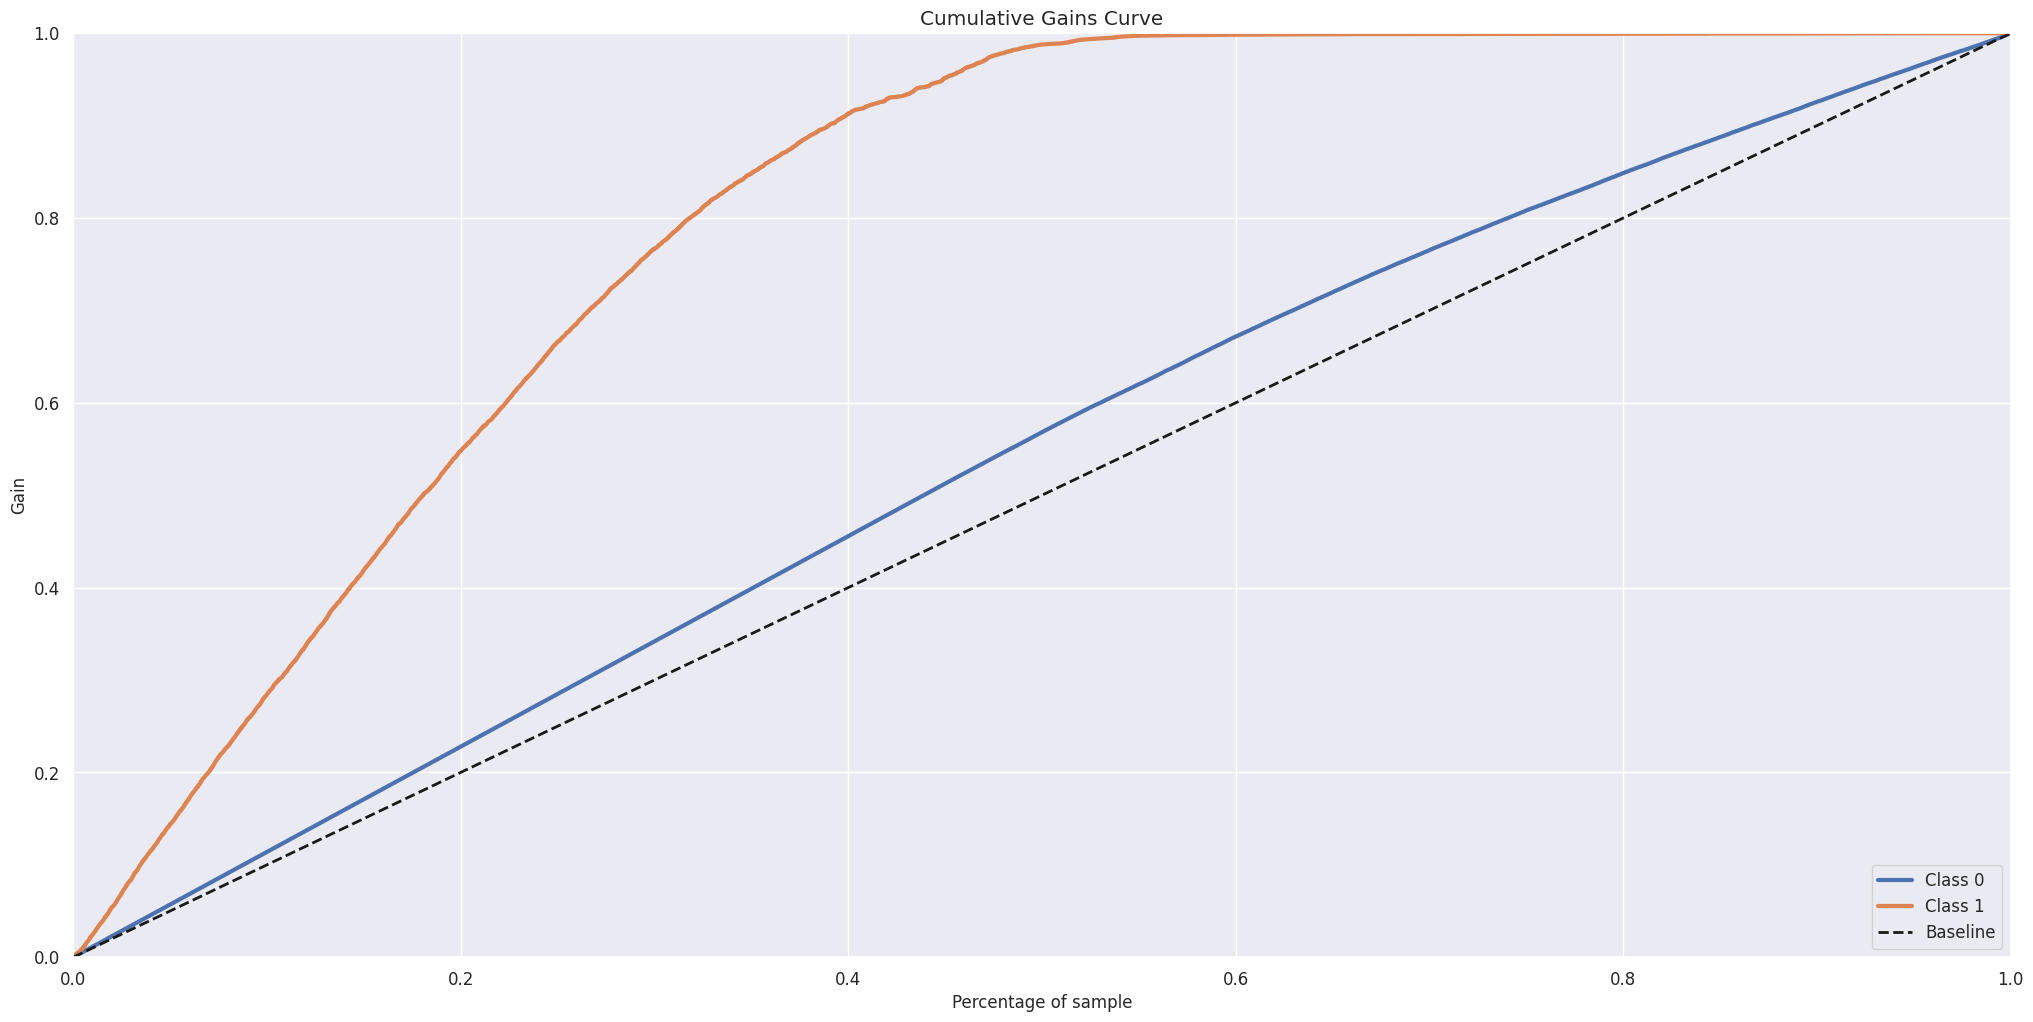

In [68]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr);

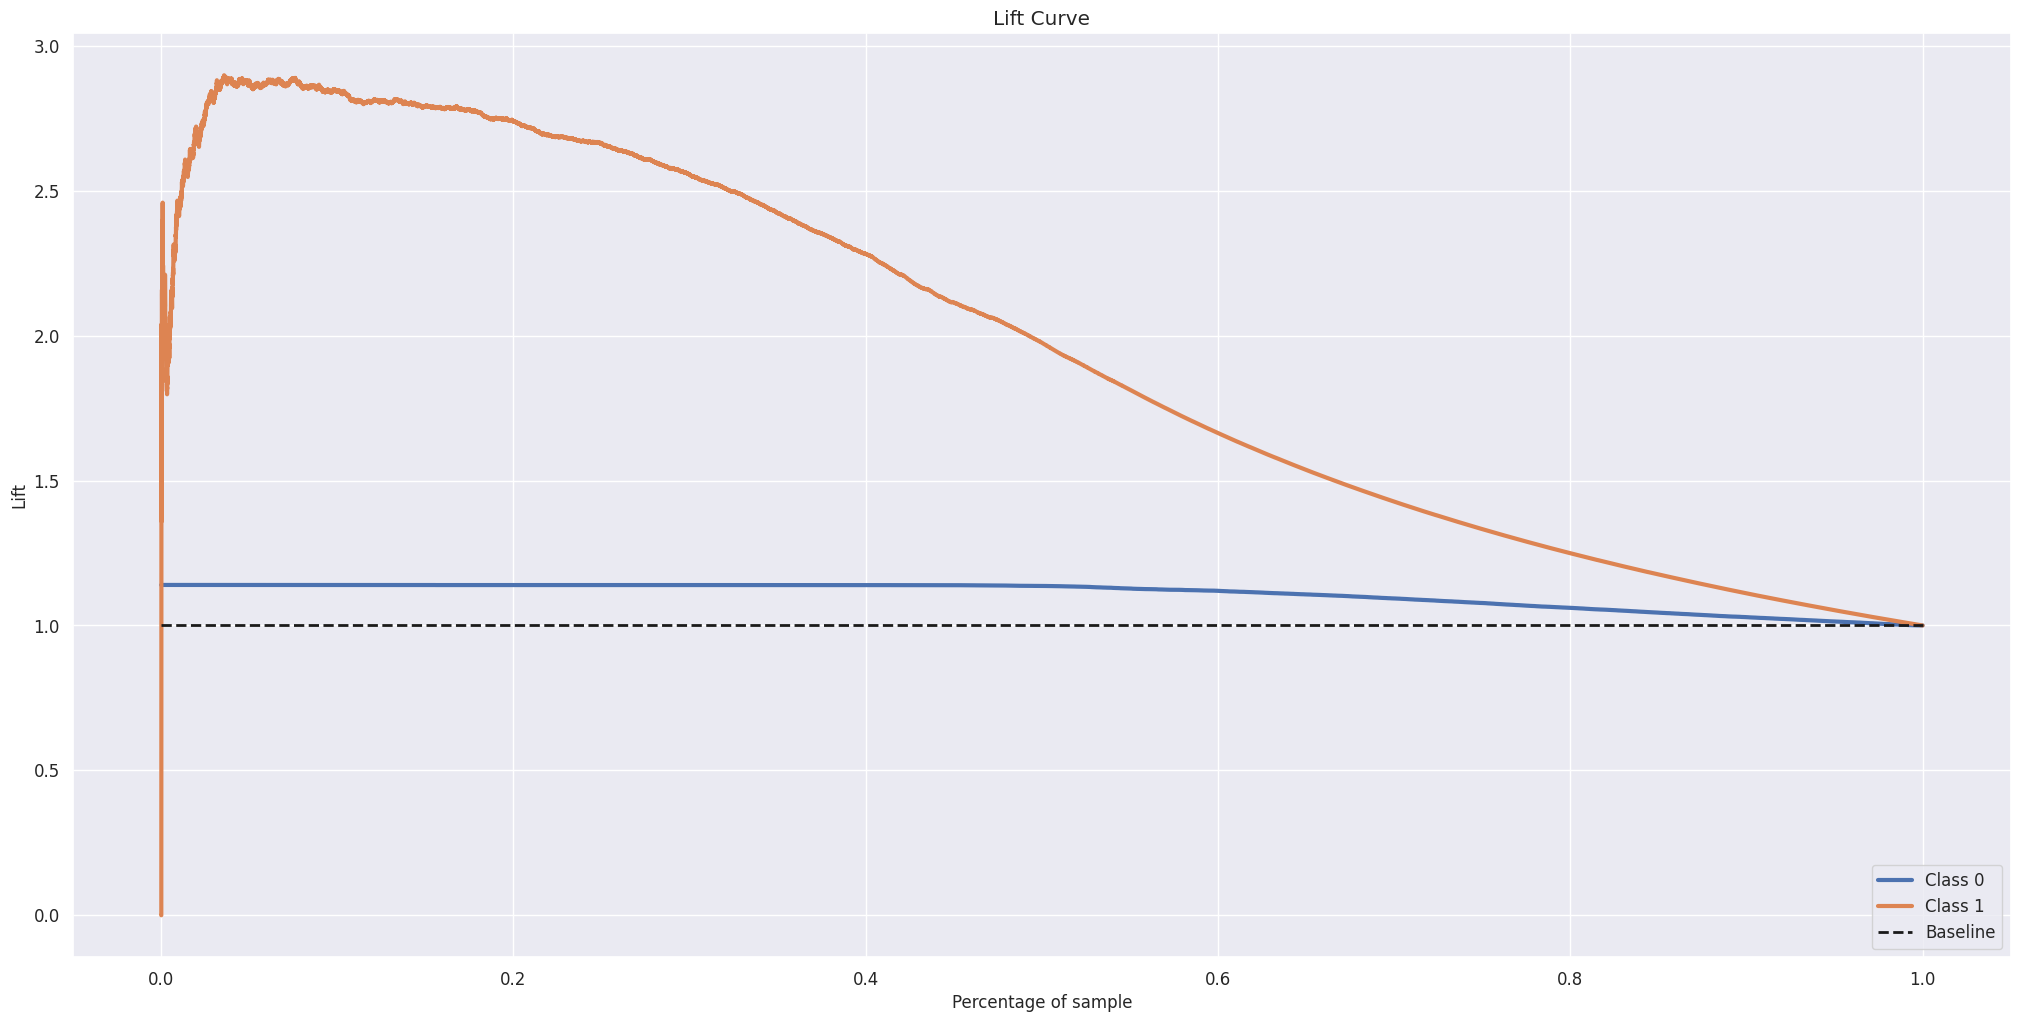

In [69]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lr);

In [70]:
lr_score = ml_top_k_scores('Linear Regression Model', y_validation, yhat_lr, 20000)
lr_score

,Precision_at_k,Recall_at_k,F1_at_k
Linear Regression Model,0.3233,0.6918,0.4407


In [71]:
lr_score_cv = ml_cv('Linear Regression Model', lr, x_train, y_train)
lr_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,Linear Regression Model,0.33 +/- 0.00223,0.7 +/- 0.00475,0.44 +/- 0.00303


## 6.4 XGBoost Classifier

In [72]:
%%time

#model Definition
model_xgb = xgb.XGBClassifier(objective= 'binary:logistic',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.7,
                              scale_pos_weight=7,
                              random_state=32)

eval_set = [(x_validation, y_validation)]

#Model Training
model_xgb.fit( x_train,
               y_train,
               eval_set = eval_set,
               eval_metric = 'logloss',
               early_stopping_rounds=50,
               verbose=False)

#Model Predict
yhat_xgb = model_xgb.predict_proba( x_validation )
print(f"XGBoost logloss on the evaluation set: {log_loss(y_validation, yhat_xgb):.5f}")

XGBoost logloss on the evaluation set: 0.51507
CPU times: user 1min 13s, sys: 496 ms, total: 1min 13s
Wall time: 28.9 s


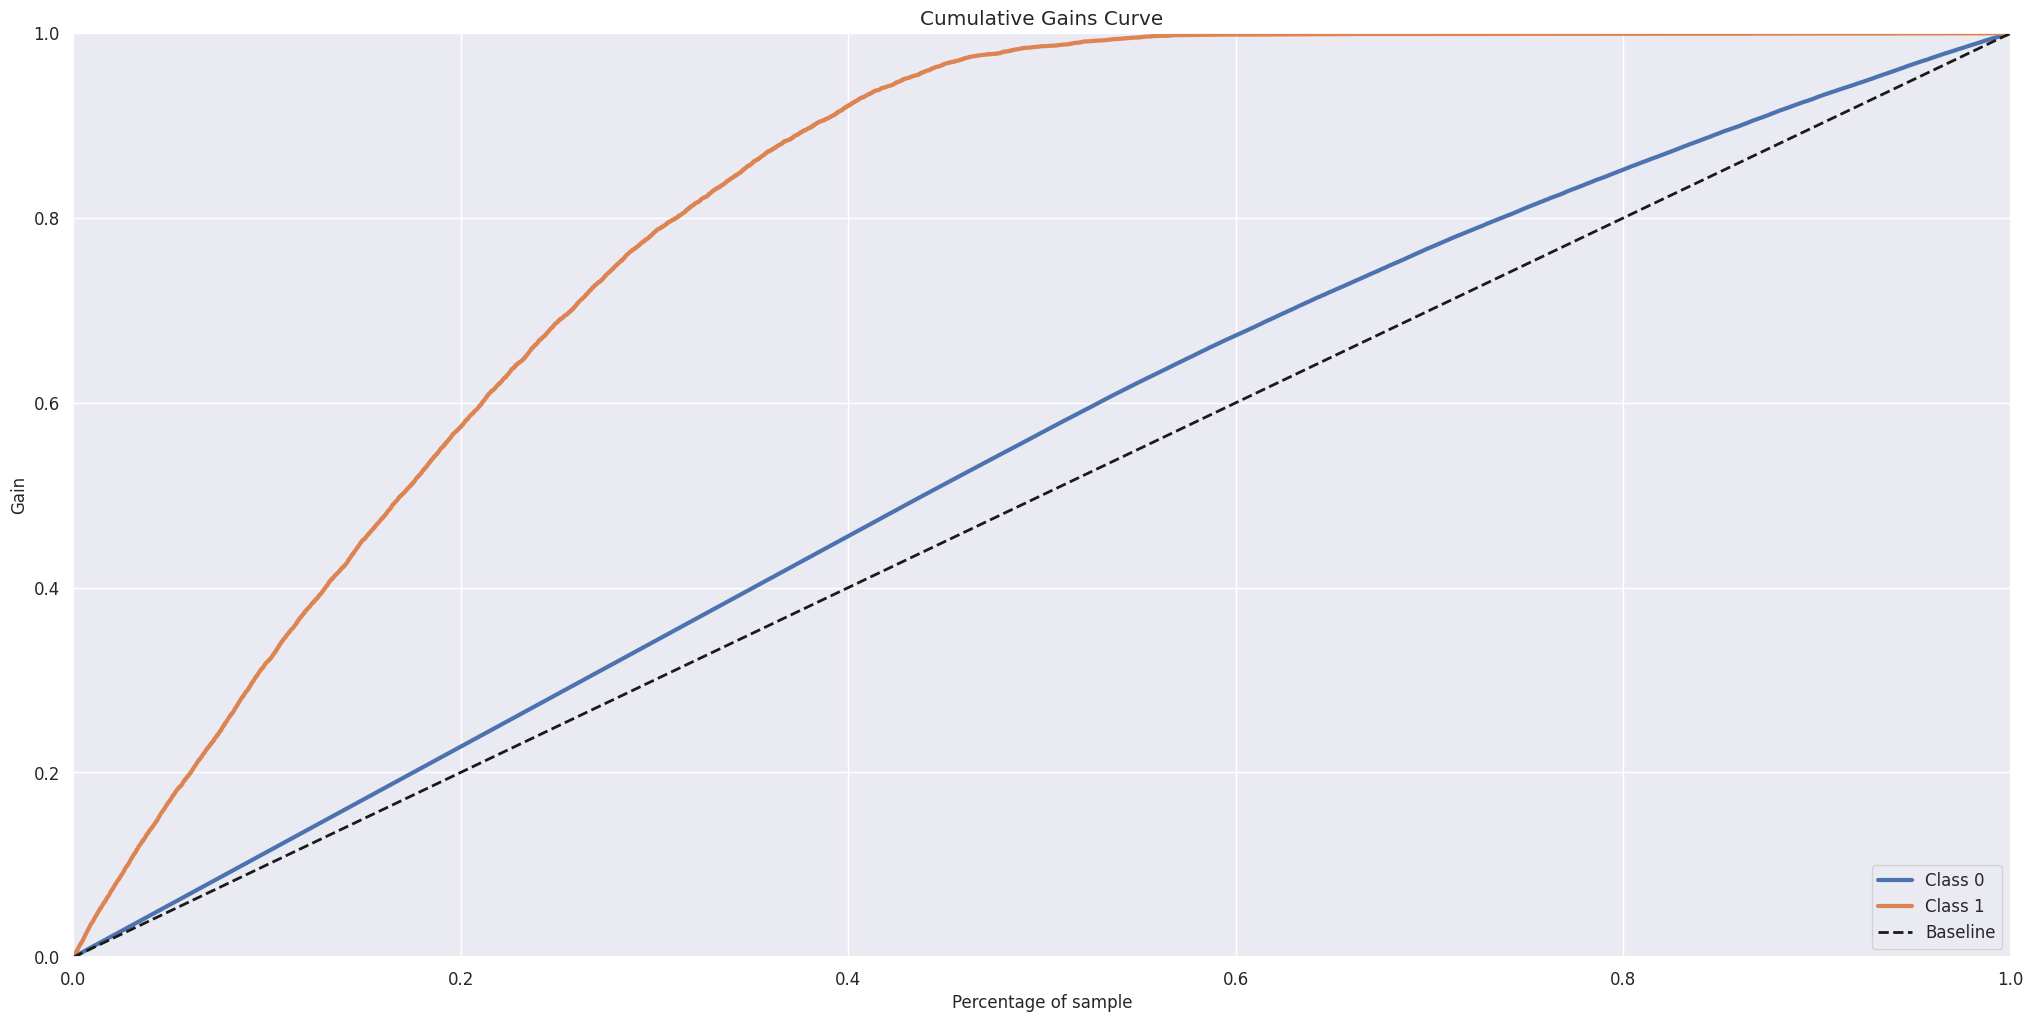

In [73]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_xgb);

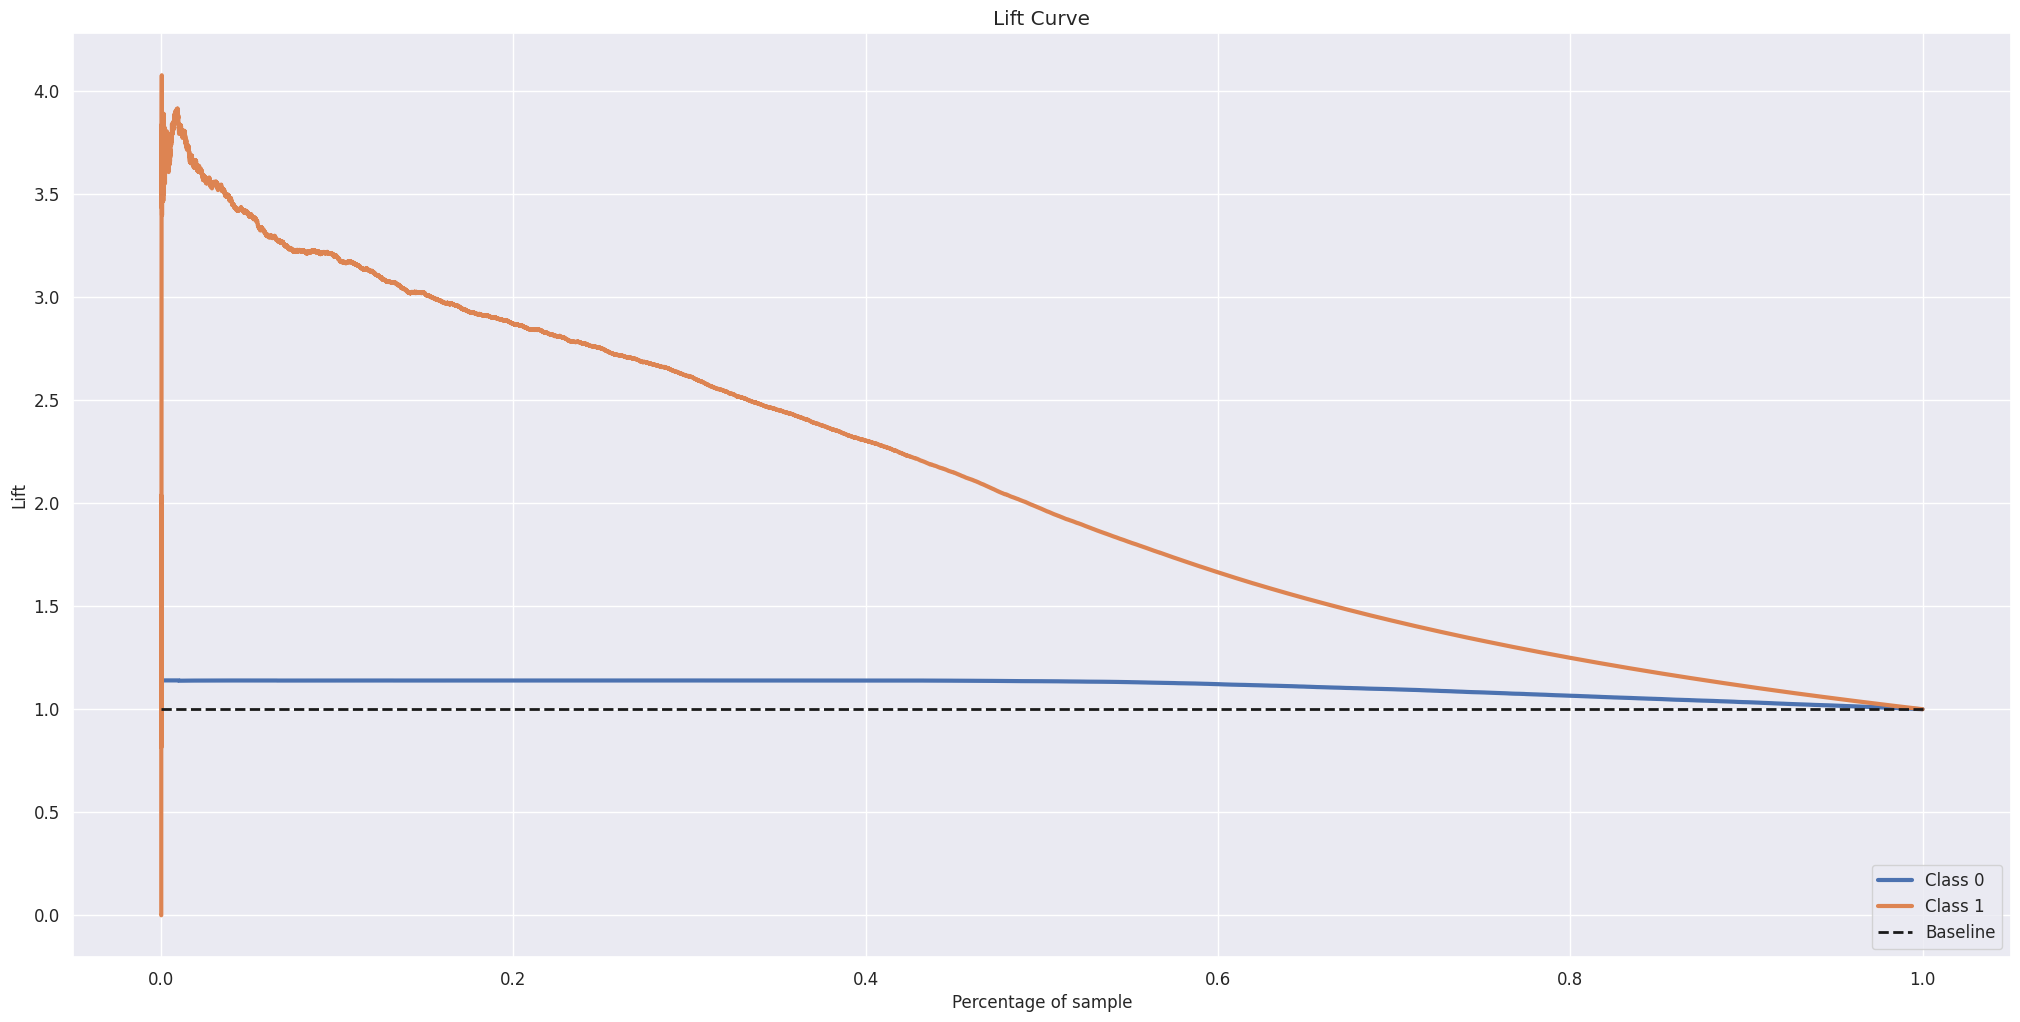

In [74]:
#Lift Gain Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb);

In [75]:
xgb_score = ml_top_k_scores('XGBoost Model', y_validation, yhat_xgb, 20000)
xgb_score

,Precision_at_k,Recall_at_k,F1_at_k
XGBoost Model,0.3328,0.712,0.4536


In [76]:
xgb_score_cv = ml_cv('XGBoost Model', model_xgb, x_train, y_train)
xgb_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,XGBoost Model,0.33 +/- 0.00293,0.71 +/- 0.00625,0.45 +/- 0.00399


## 6.5 LGBM Classifier

In [77]:
%%time

#Model Definition
model_lgbm = lgbm.LGBMClassifier(objective='binary',
                                n_estimators=100,
                                max_depth=10,
                                num_leaves = 700,
                                subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=7,
                                random_state=32)

eval_set = [(x_validation, y_validation)]

#Model Training
model_lgbm.fit(x_train,
               y_train,
               eval_set = eval_set,
               early_stopping_rounds=50,
               eval_metric='binary_logloss',
               verbose=False)

#Model Predict
yhat_lgbm = model_lgbm.predict_proba( x_validation )
ylgbm_value = model_lgbm.predict( x_validation )
print(f"LGBM logloss on the evaluation set: {log_loss(y_validation, yhat_lgbm):.5f}")

LGBM logloss on the evaluation set: 0.32356
CPU times: user 11.8 s, sys: 130 ms, total: 11.9 s
Wall time: 5.13 s


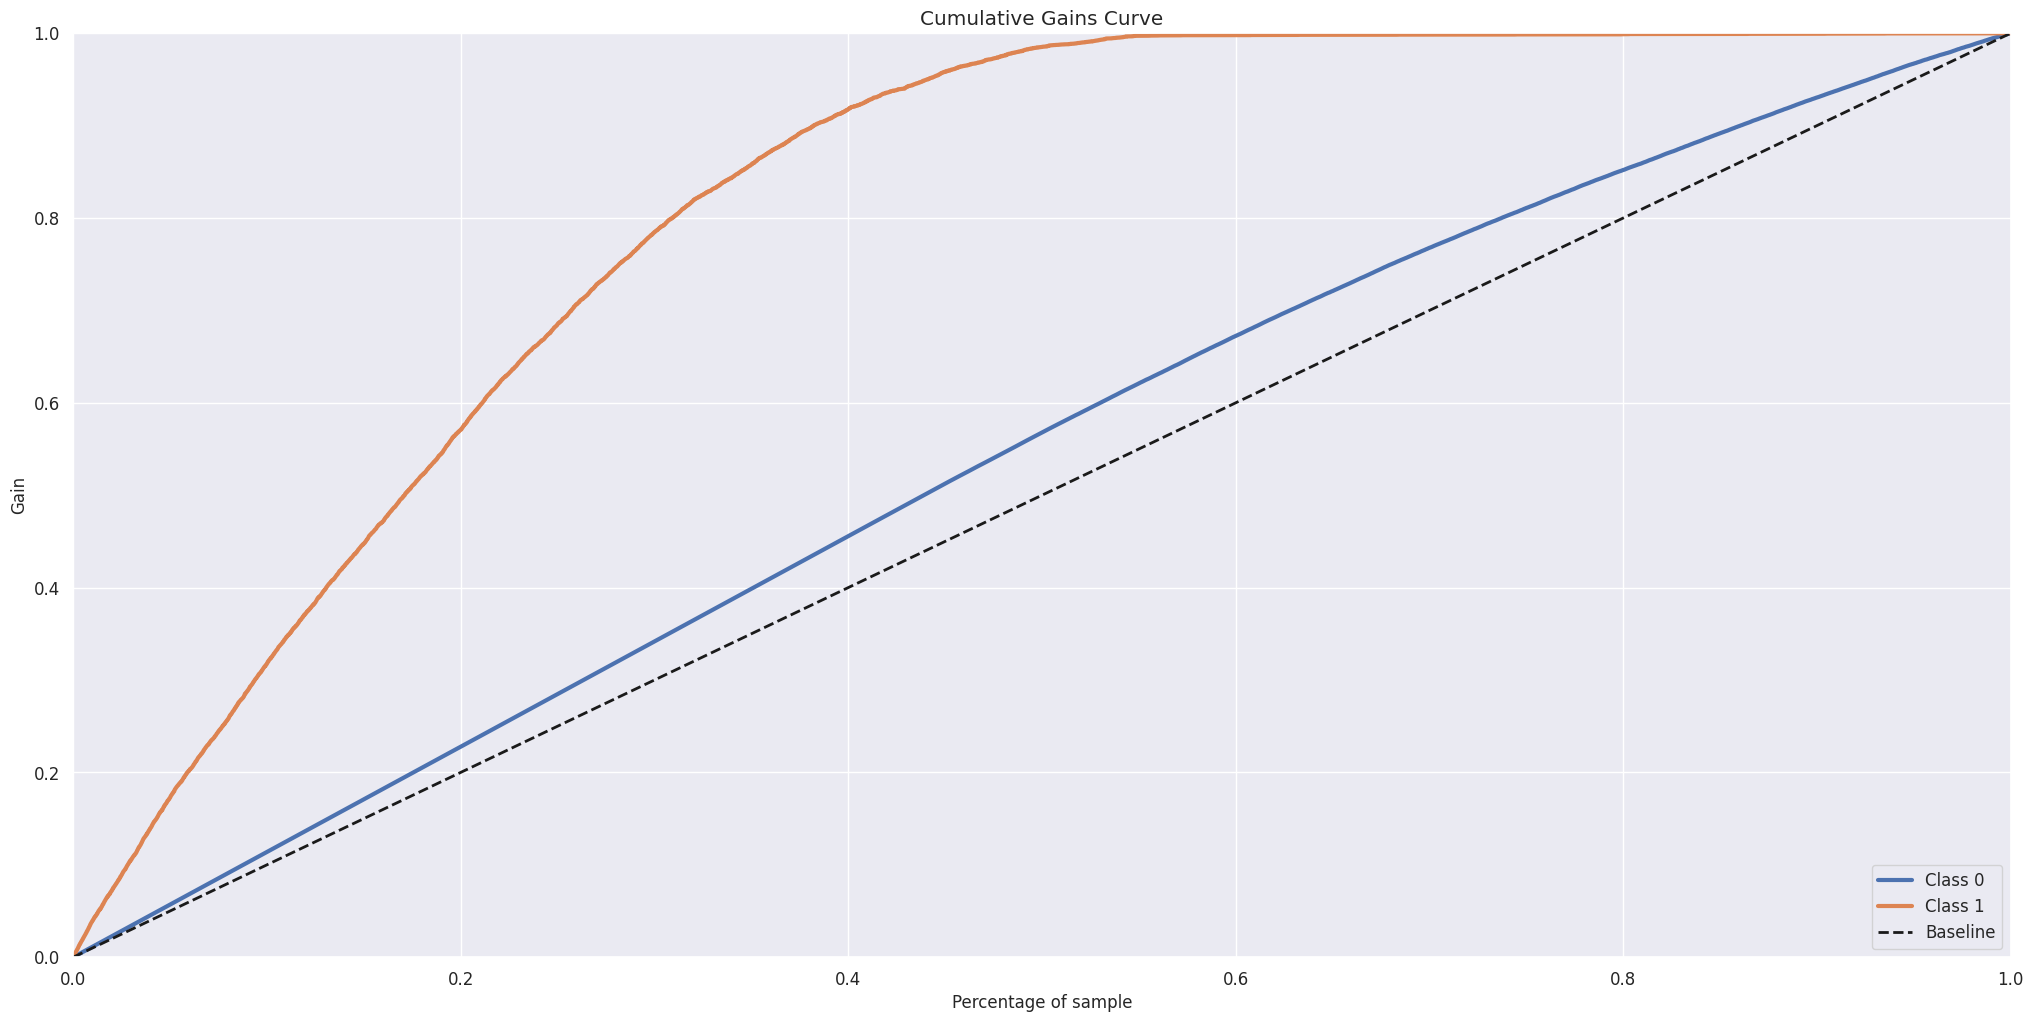

In [78]:
#Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lgbm);

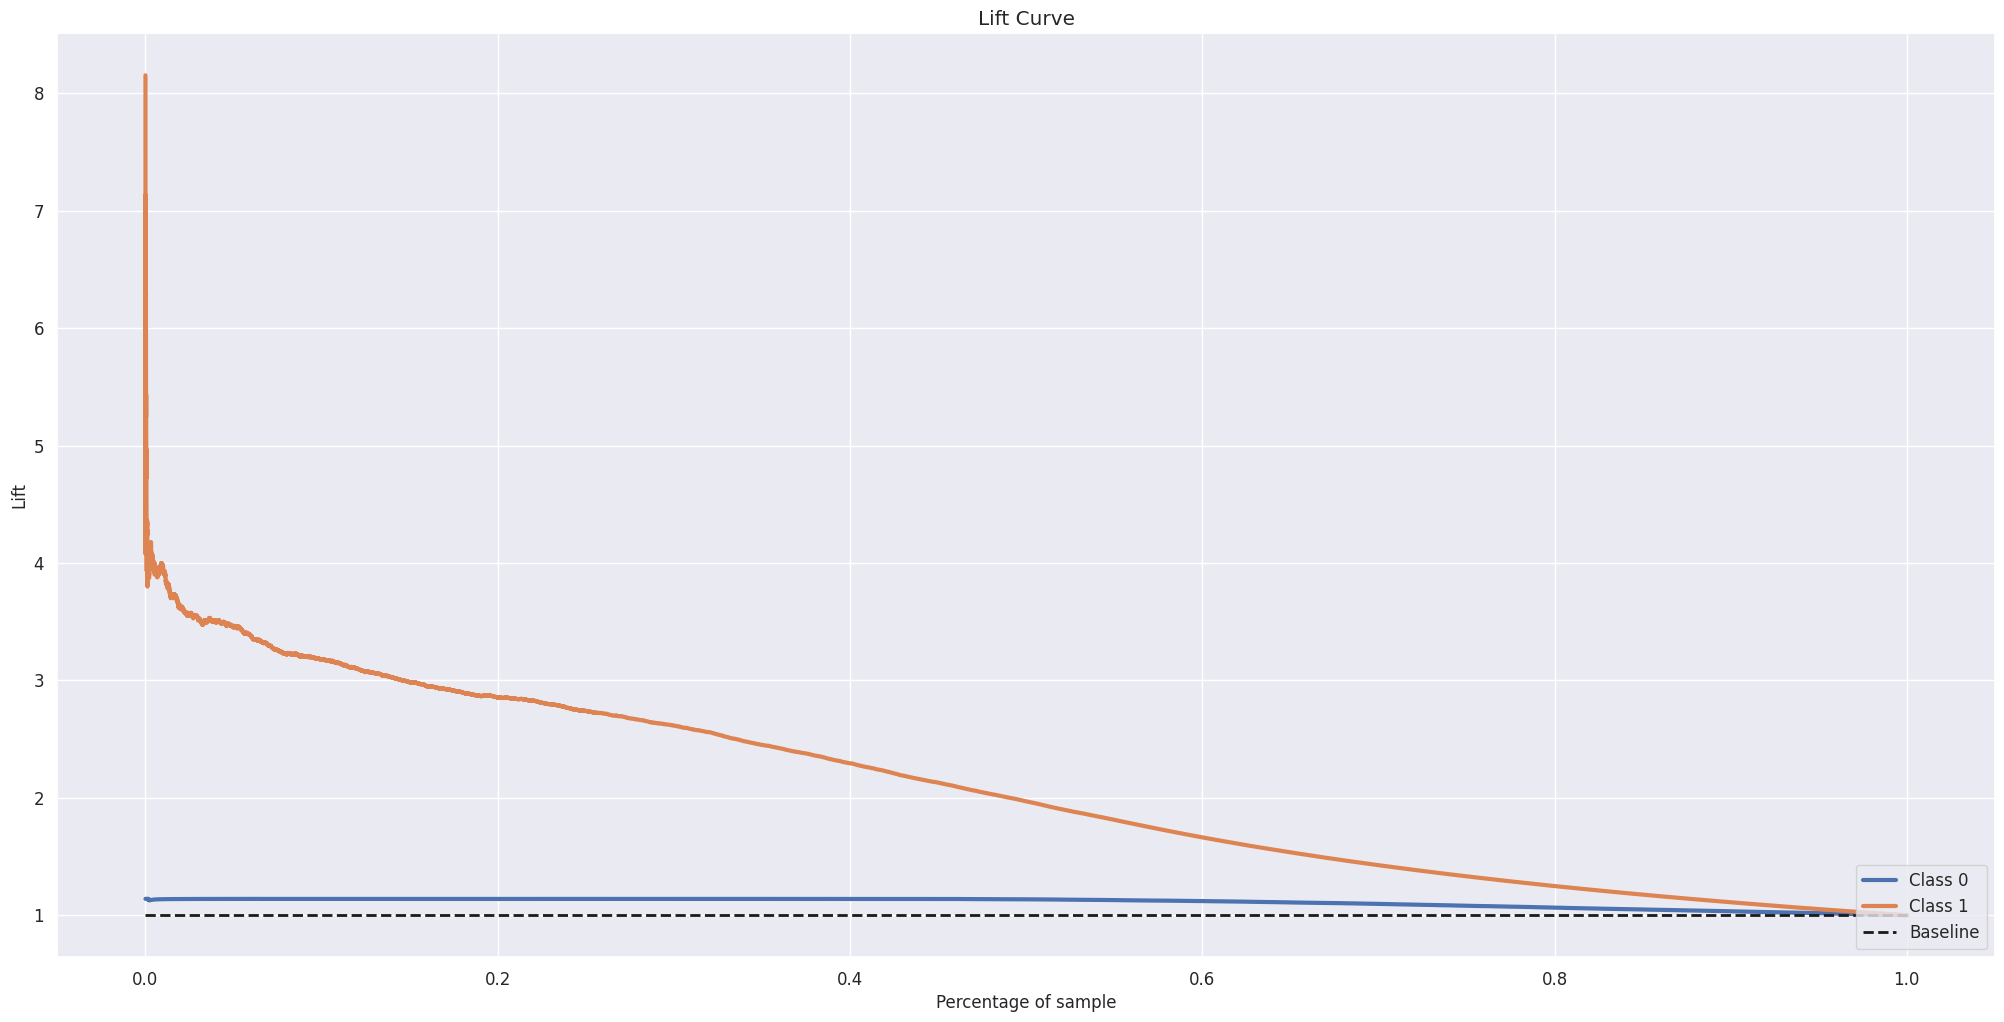

In [79]:
#Lift Gain Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm);

In [80]:
lgbm_score = ml_top_k_scores('LGBM Model', y_validation, yhat_lgbm, 20000)
lgbm_score

,Precision_at_k,Recall_at_k,F1_at_k
LGBM Model,0.3326,0.7117,0.4534


In [81]:
lgbm_score_cv = ml_cv('LGBM Model', model_lgbm, x_train, y_train)
lgbm_score_cv

,Model Name,Precision@k,Recall@k,F1_score@k
0,LGBM Model,0.31 +/- 0.00396,0.66 +/- 0.00847,0.42 +/- 0.0054


## 6.6 Performance Results Comparative



*   Validation Dataset



In [82]:
val_scores = pd.concat([dummy_score, knn_score, lr_score, xgb_score, lgbm_score])
val_scores

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1230,0.2633,0.1677
KNN Model,0.2933,0.6275,0.3997
Linear Regression Model,0.3233,0.6918,0.4407
XGBoost Model,0.3328,0.7120,0.4536
LGBM Model,0.3326,0.7117,0.4534




*   Cross Validation Dataset



In [83]:
cv_scores = pd.concat([dummy_score_cv, knn_score_cv, lr_score_cv, xgb_score_cv, lgbm_score_cv])
cv_scores

,Model Name,Precision@k,Recall@k,F1_score@k
0,Dummy Model,0.12 +/- 0.00127,0.27 +/- 0.00271,0.17 +/- 0.00173
0,KNN Model,0.28 +/- 0.0033,0.59 +/- 0.00706,0.38 +/- 0.00449
0,Linear Regression Model,0.33 +/- 0.00223,0.7 +/- 0.00475,0.44 +/- 0.00303
0,XGBoost Model,0.33 +/- 0.00293,0.71 +/- 0.00625,0.45 +/- 0.00399
0,LGBM Model,0.31 +/- 0.00396,0.66 +/- 0.00847,0.42 +/- 0.0054




*   Given the Results, the Machine Learning model chosen for hyperparameter fine tunning and deploy was XGB Model, due to presenting better performance on our main metric of analysis (Recall@K), as well as presenting better generalization as observed on Cross Validation.



# 7.0 HYPERPARAMETER FINE TUNNING

In [ ]:
#param = { 'n_estimators': [50, 100, 150],
#          'eta':[0.01, 0.03],
#          'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytee': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15]}
#
#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    #model
#    model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror',
#                                  n_estimators= hp['n_estimators'],
#                                  eta= hp['eta'],
#                                  max_depth= hp['max_depth'],
#                                  subsample= hp['subsample'],
#                                  colsample_bytee= hp['colsample_bytee'],
#                                  min_child_weight= hp['min_child_weight']).fit(x_train, y_train)
#
    #performance
#    result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

In [ ]:
#Optuna Tunning
study = optuna.create_study(direction='maximize', study_name='XGB Classifier', pruner=optuna.pruners.MedianPruner())
function = lambda trial: objective(trial, x_train, y_train, 20000)
study.optimize(function, n_trials=50)

[I 2023-09-01 22:08:09,882] A new study created in memory with name: XGB Classifier
[I 2023-09-01 22:08:27,683] Trial 0 finished with value: 0.6762312633832976 and parameters: {'booster': 'gbtree', 'max_depth': 1, 'learning_rate': 0.03752984148061845, 'n_estimators': 150, 'min_child_weight': 1, 'scale_pos_weight': 10, 'subsample': 0.7100000000000001, 'colsample_bytree': 0.11, 'reg_alpha': 0.4896886775968955, 'reg_lambda': 0.40185040290564694}. Best is trial 0 with value: 0.6762312633832976.
[I 2023-09-01 22:11:04,287] Trial 1 finished with value: 0.7022483940042826 and parameters: {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.13867118784172047, 'n_estimators': 350, 'min_child_weight': 9, 'scale_pos_weight': 10, 'subsample': 0.6100000000000001, 'colsample_bytree': 0.6100000000000001, 'reg_alpha': 0.9152997980767628, 'reg_lambda': 0.34594996585062565}. Best is trial 1 with value: 0.7022483940042826.
[I 2023-09-01 22:12:12,279] Trial 2 finished with value: 0.6717344753747323 an

In [ ]:
print(f"\tBest value (Recall_at_K): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (Recall_at_K): 0.70835
	Best params:
		booster: dart
		max_depth: 3
		learning_rate: 0.11973617708189595
		n_estimators: 150
		min_child_weight: 5
		scale_pos_weight: 9
		subsample: 0.7100000000000001
		colsample_bytree: 0.51
		reg_alpha: 0.19310948764702202
		reg_lambda: 0.24843907704450086


In [ ]:
plot_param_importances(study)

# 8.0 PERFORMANCE METRICS & RESULT ANALYSIS

## 8.1 Tuned Model Performance

In [84]:
%%time

params = {'booster': 'dart',
          'max_depth': 3,
          'learning_rate': 0.11,
          'n_estimators': 350,
          'min_child_weight': 5,
          'scale_pos_weight': 10,
          'subsample': 0.91,
          'colsample_bytree': 0.91,
          'reg_alpha': 0.18,
          'reg_lambda': 0.89}


#Model Definition
model_xgb = xgb.XGBClassifier(**params)

eval_set = [(x_validation, y_validation)]

#Model Training
model_xgb.fit(x_train,
              y_train,
              eval_set = eval_set,
              early_stopping_rounds=50,
              eval_metric='logloss',
              verbose=False)

#Model Predict
yhat_xgb = model_xgb.predict_proba( x_validation )

CPU times: user 27min 42s, sys: 3.9 s, total: 27min 46s
Wall time: 7min 27s


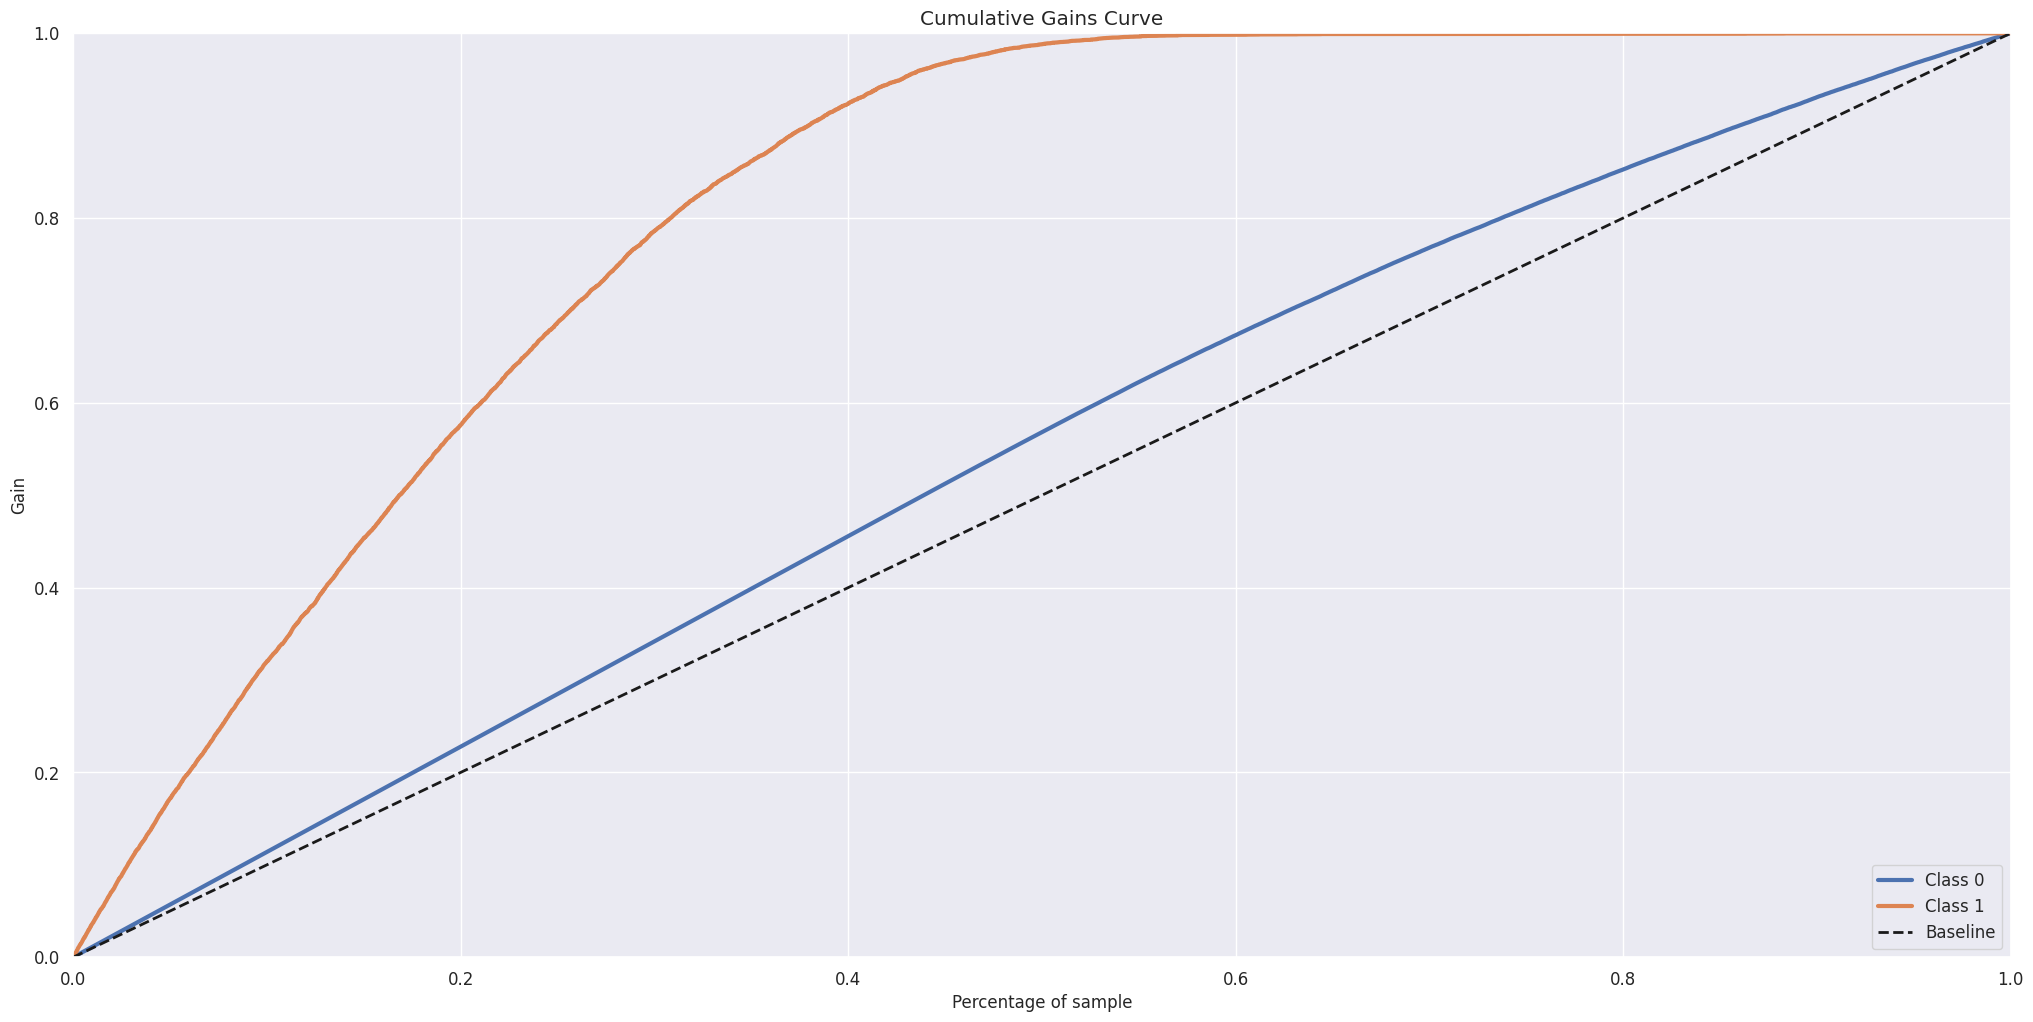

In [85]:
skplt.metrics.plot_cumulative_gain( y_validation, yhat_xgb);

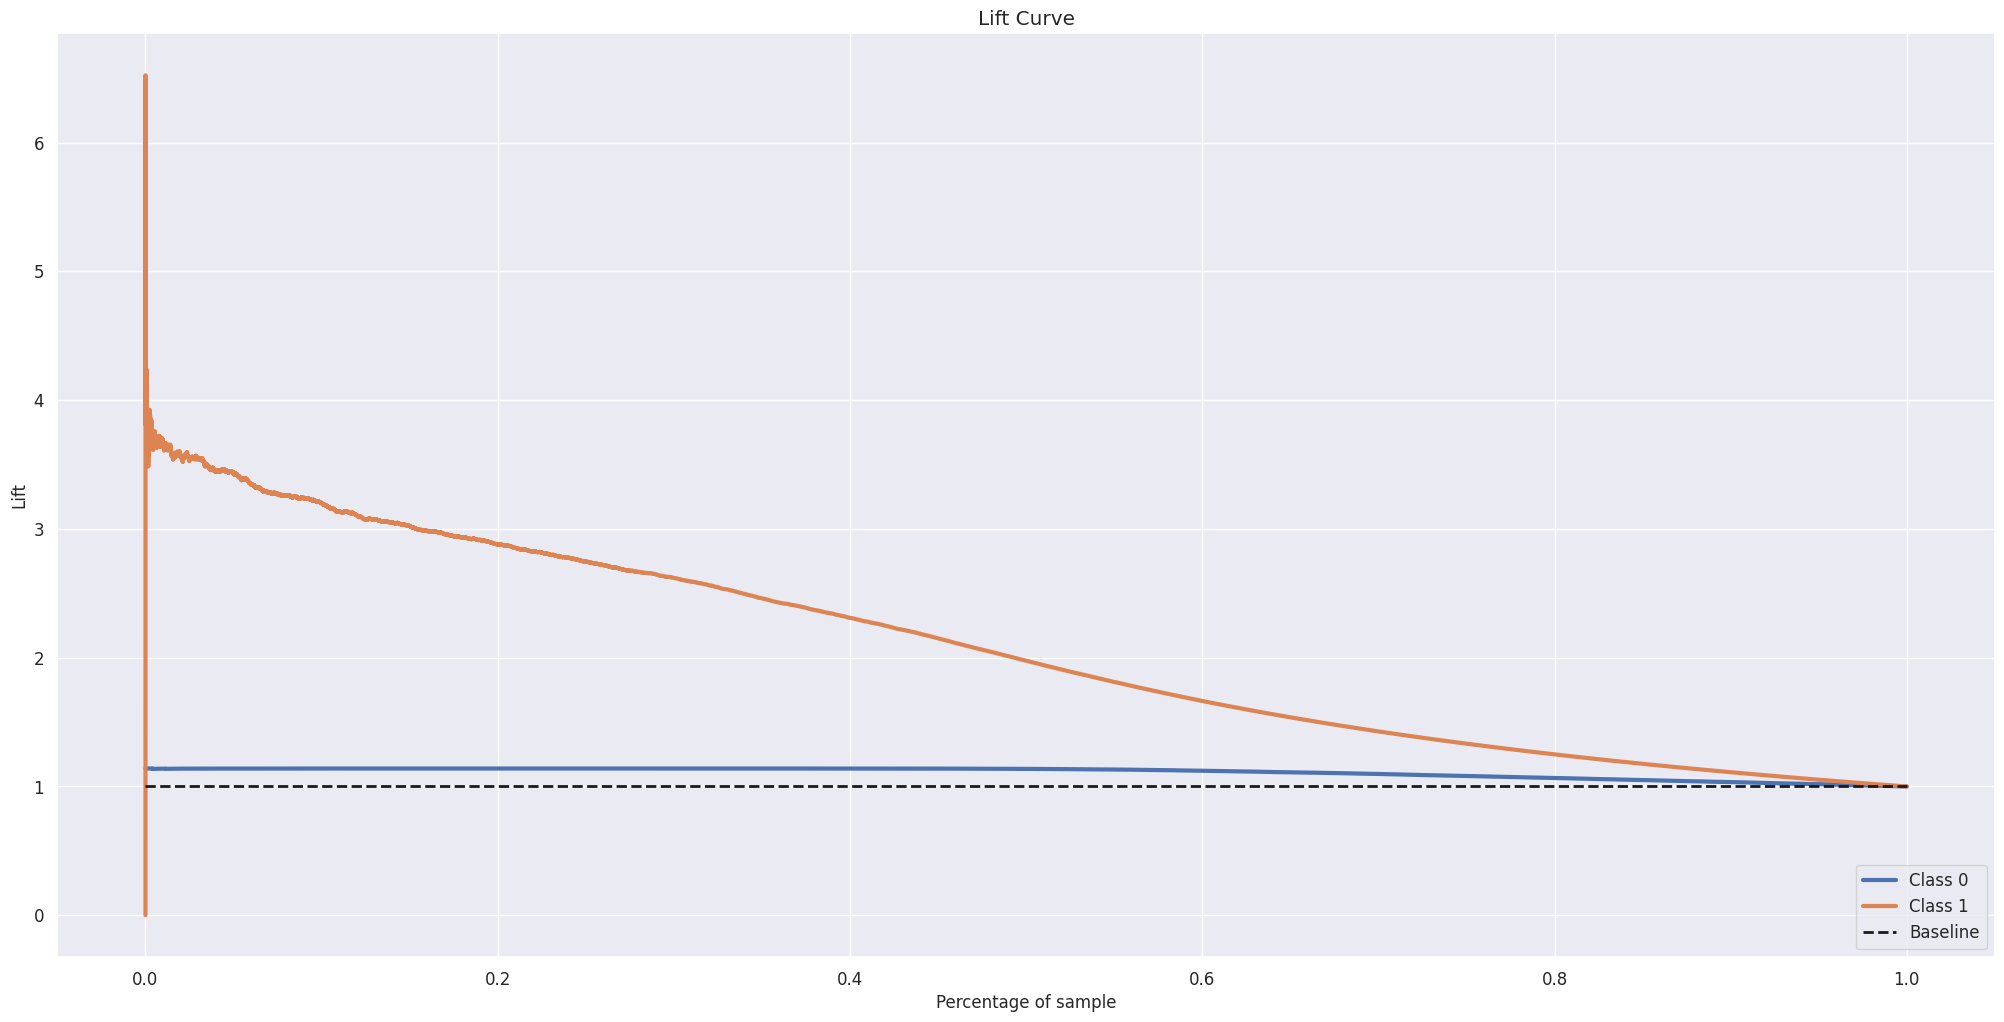

In [86]:
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb);

In [87]:
ml_top_k_scores('XGB Model', y_validation, yhat_xgb, 20000)

,Precision_at_k,Recall_at_k,F1_at_k
XGB Model,0.3327,0.7118,0.4534


In [88]:
ml_cv('XGB Model', model_xgb, x_train, y_train)

,Model Name,Precision@k,Recall@k,F1_score@k
0,XGB Model,0.33 +/- 0.00361,0.71 +/- 0.00773,0.45 +/- 0.00493


In [89]:
y_validation.sum()

9348

In [90]:
yhat_xgb[:, 1].max()

0.9479012

## 8.2 ROI Curve (Return of Investment)

In [91]:
df_roi = x_validation.copy()

#response
df_roi['response'] = y_validation.to_list()

#Predict Score Ordering
df_roi['score'] = yhat_xgb[:, 1]
df_roi = df_roi.sort_values('score', ascending=False)


In [98]:
df_roi = x_validation.copy()

#response
df_roi['response'] = y_validation.to_list()

#Predict Score Ordering
df_roi['score'] = yhat_xgb[:, 1]
df_roi = df_roi.sort_values('score', ascending=False)

#Percentage of Interested Clients
df_roi['real_cummulative'] = df_roi['response'].cumsum()
df_roi['real_cummulative_perc'] = 100 * df_roi['real_cummulative']/df_roi['response'].sum()

#Base Percentage
df_roi['base'] = range(1, len(df_roi)+1)
df_roi['base_cummulative_perc'] = 100*df_roi['base']/len(df_roi)

#Creating 10 buckets/bins to group clients
df_roi['bucket'] = df_roi['score'].apply(lambda x: 0.9 if x >= 0.90 else
                                                   0.8 if (x >= 0.80) & (x < 0.90) else
                                                   0.7 if (x >= 0.70) & (x < 0.80) else
                                                   0.6 if (x >= 0.60) & (x < 0.70) else
                                                   0.5 if (x >= 0.50) & (x < 0.60) else
                                                   0.4 if (x >= 0.40) & (x < 0.50) else
                                                   0.3 if (x >= 0.30) & (x < 0.40) else
                                                   0.2 if (x >= 0.20) & (x < 0.30) else
                                                   0.1 if (x >= 0.10) & (x < 0.20) else 0.01)

#Client Bucket Grouping
df_roi = df_roi[['score', 'bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df_roi.columns = df_roi.columns.droplevel()
df_roi.columns = ['bucket', 'min_score', 'clients']
#df_roi.columns = ['bucket', 'clients', 'min_score']

*   Considering hipothetically, that each client conversion grants $40 for a cost of $4 per call, we have:

In [99]:
gross_revenue_per_converted_client = 40
client_cost = 4

#gross_revenue
df_roi['bucket_gross_revenue'] = gross_revenue_per_converted_client * df_roi['clients'] * df_roi['min_score']
df_roi['bucket_cost'] = client_cost * df_roi['clients']

#Base percentual per bucket
df_roi = df_roi.sort_values('bucket', ascending=False)
df_roi['base'] = df_roi['clients'].cumsum()/df_roi['clients'].sum()

#Liquid Revenue per bucket
df_roi['bucket_revenue'] = df_roi['bucket_gross_revenue'] - df_roi['bucket_cost']

#Cummulative Liquid Revenue
df_roi['accumulated_revenue'] = df_roi['bucket_revenue'].cumsum()
df_roi

,bucket,min_score,clients,bucket_gross_revenue,bucket_cost,base,bucket_revenue,accumulated_revenue
9,0.90,0.900682,67,2413.828006,268,0.000879,2145.828006,2145.828006
8,0.80,0.800024,16148,516751.715631,64592,0.212734,452159.715631,454305.543637
7,0.70,0.700357,8609,241174.963899,34436,0.325680,206738.963899,661044.507536
6,0.60,0.600018,5110,122643.708563,20440,0.392721,102203.708563,763248.216099
5,0.50,0.500246,3888,77798.330269,15552,0.443730,62246.330269,825494.546368
4,0.40,0.400076,1956,31301.974368,7824,0.469392,23477.974368,848972.520736
3,0.30,0.300074,1343,16119.988683,5372,0.487012,10747.988683,859720.509419
2,0.20,0.200421,2360,18919.696498,9440,0.517974,9479.696498,869200.205917
1,0.10,0.100030,1959,7838.382133,7836,0.543675,2.382133,869202.588050
0,0.01,0.000013,34782,17.740384,139128,1.000000,-139110.259616,730092.328434


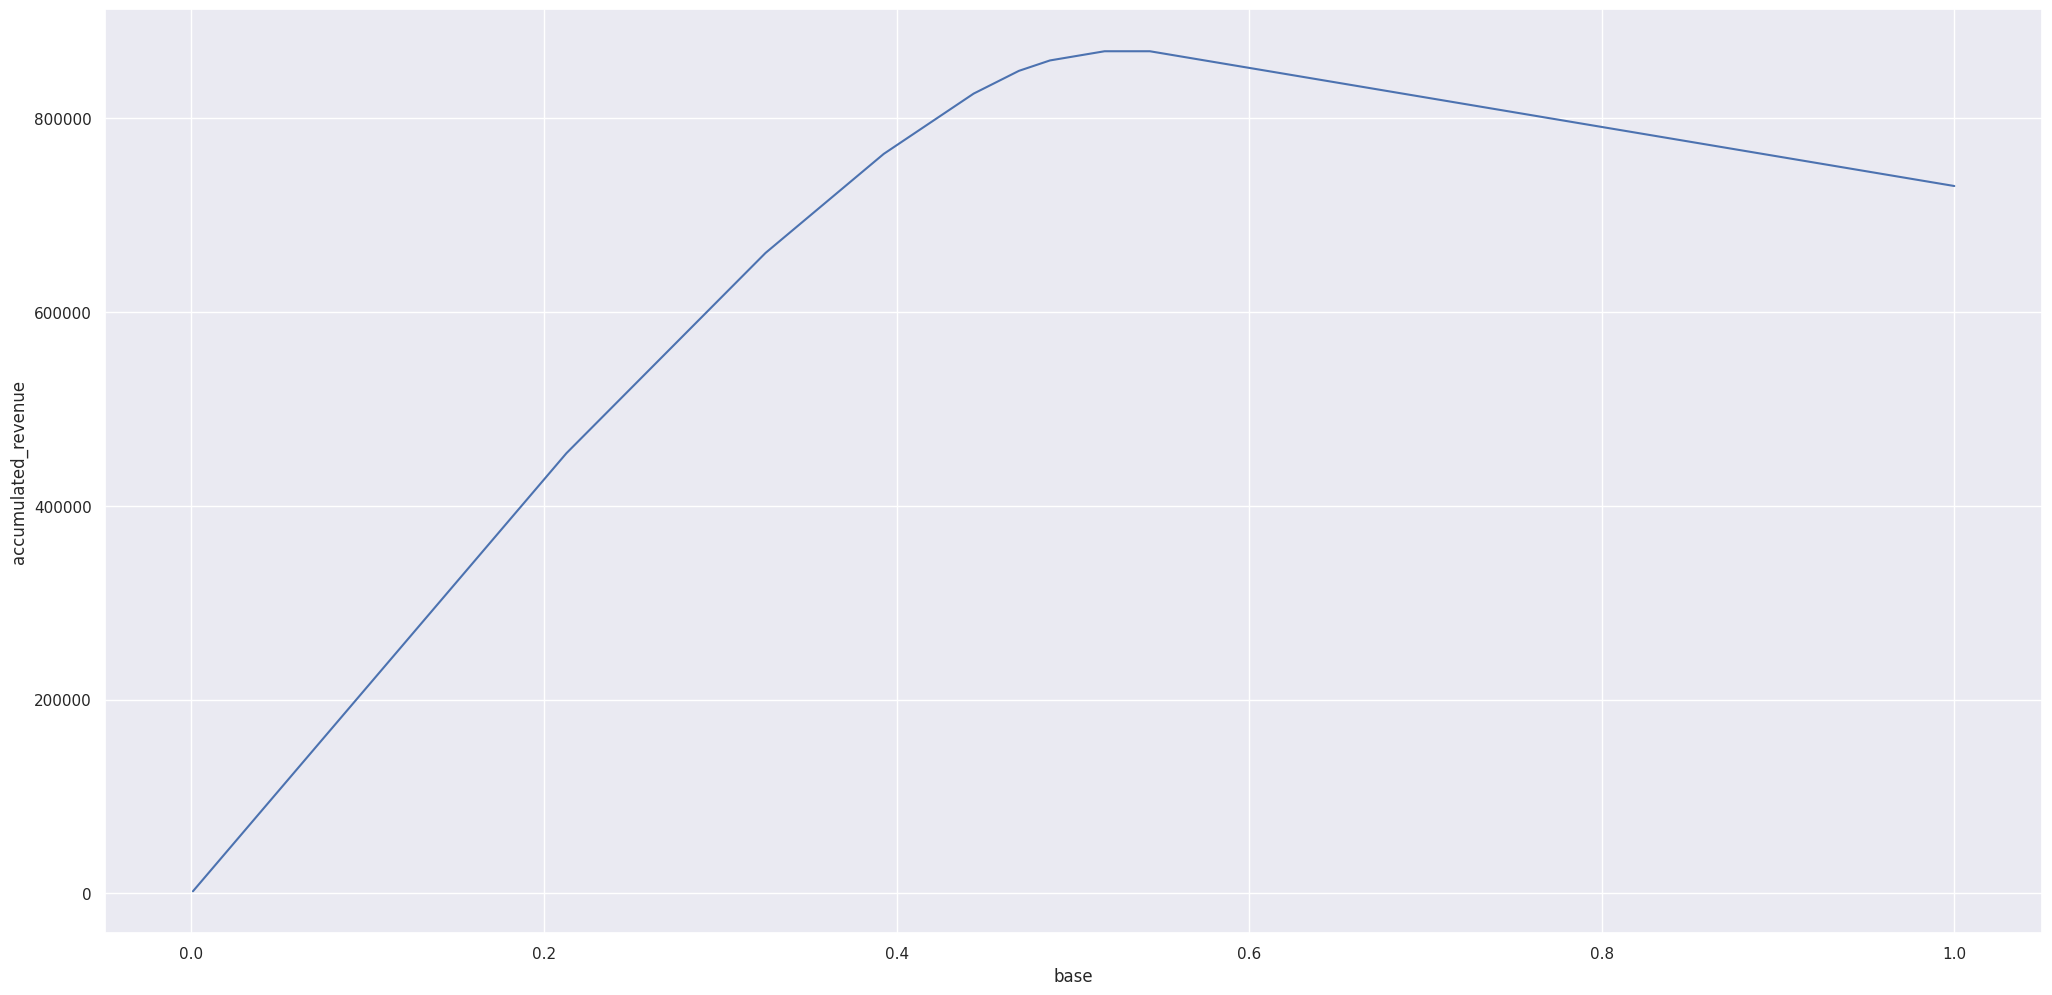

In [100]:
roi_curve = df_roi[df_roi['min_score'] >= 0.10]
sns.lineplot(x='base', y='accumulated_revenue', data=df_roi);

## 8.3 Business Q&A

In [102]:
#Overall Validation Data Info
X_validation.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76222 entries, 154612 to 83974
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      76222 non-null  int64  
 1   age                     76222 non-null  float64
 2   region_code             76222 non-null  float64
 3   policy_sales_channel    76222 non-null  float64
 4   previously_insured      76222 non-null  int64  
 5   annual_premium          76222 non-null  float64
 6   vintage                 76222 non-null  float64
 7   driving_license         76222 non-null  int64  
 8   vehicle_age             76222 non-null  float64
 9   vehicle_damage          76222 non-null  int64  
 10  scored_sales_channel    76222 non-null  int64  
 11  vehicle_age_score       76222 non-null  int64  
 12  region_score            76222 non-null  int64  
 13  annual_premium_per_day  76222 non-null  float64
 14  annual_premium_per_age  76222 non

In [105]:
#Counting the
unique_values, counts = np.unique(y_validation, return_counts=True)

for item, count in zip(unique_values, counts):
    print(f'{item}:{count}')

0:66874
1:9348


In [108]:
ml_top_k_scores('XGB Model', y_validation, yhat_xgb, 40000)

,Precision_at_k,Recall_at_k,F1_at_k
XGB Model,0.232,0.9929,0.3762


In [116]:
ml_top_k_scores('XGB Model', y_validation, yhat_xgb, 23500)

,Precision_at_k,Recall_at_k,F1_at_k
XGB Model,0.3182,0.8001,0.4554


### 8.3.1 What percentage of customers are interested in purchasing auto insurance? Will the sales team be able to reach them by making 20,000 calls?

1.  Our validation dataset consists of 76222 entries, with 9348 being the sum of those with positive response (response=1). Our tuned model then recalled a total of 6709 entries out of all positive responses for the first 20000 calls (Recall@20000 = 0.7177 = 71,77%)

2.  Given that the obtained value for Recall@20000 from the Dummy model was 27% during the cross validation section(2524 entries), we can conclude that our trained LGBM model is 2.65x times better (Lift Curve metric) than the standard one (i.e. calling the first 20000 entries of the raw dataset without training a model to rank it) for our business purposes.

### 8.3.2 If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

For 40,000 calls, the percentage of customers interested in purchasing auto insurance (Recall@40000) will be 99.29% (9261 out of 9348 people contacted amongst those who showed positive response).

### 8.3.3 How many phone calls the sales team have to make to reach 80% of the interested customers?

To reach out 80% of interested customers, there will be needed aproximately 23500 calls.


# 9.0 MODEL DEPLOYMENT

In [117]:
pickle.dump(model_xgb, open('/home/valquiriaam/repos/PA004/src/models/model_health_insurance.pkl', 'wb'))

In [ ]:
x_train.head()

## 9.1 Deploy Class

In [ ]:
class HealthInsurance:

     def __init__(self):
        self.home_path = ''
        self.ss_premium_scaler =        pickle.load(open(self.home_path + 'src/features/ss_premium_scaler.pkl', 'rb'))
        self.ss_premium_day_scaler =    pickle.load(open(self.home_path + 'src/features/ss_premium_day_scaler.pkl', 'rb'))
        self.ss_premium_age_scaler =    pickle.load(open(self.home_path + 'src/features/ss_premium_age_scaler.pkl', 'rb'))
        self.mms_age_scaler =           pickle.load(open(self.home_path + 'src/features/mms_age_scaler.pkl', 'rb'))
        self.mms_vintage_scaler =       pickle.load(open(self.home_path + 'src/features/mms_vintage_scaler.pkl', 'rb'))
        self.mms_vintage_age_scaler =   pickle.load(open(self.home_path + 'src/features/mms_vintage_age_scaler.pkl', 'rb'))
        self.fe_region_scaler =         pickle.load(open(self.home_path + 'src/features/fe_region_scaler.pkl', 'rb'))
        self.te_channel_scaler =        pickle.load(open(self.home_path + 'src/features/te_channel_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        #data formating/cleaning
        df1['region_code'] = df1['region_code'].astype(np.int64)
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)
        df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        return df1

    def reorder_data(self, df2):
        # Reorder/Rename Columns
        reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
                           'previously_insured', 'annual_premium', 'vintage',
                           'driving_license', 'vehicle_age', 'vehicle_damage', 'response']

        df2 = df2.reindex(columns=reorder_columns)

        return df2

    def feature_engineering(self, df3):
        #vehicle_age_score
        vehicle_age_dict = {'< 1 Year': 1,
                            '1-2 Year': 2,
                            '> 2 Years': 3}
        df3['vehicle_age_score'] = df3['vehicle_age'].map(vehicle_age_dict)

        #annual premium paid per day
        df3['annual_premium_per_day'] = df3['annual_premium']/df3['vintage']

        #annual premium divided per age
        df3['annual_premium_per_age'] = df3['annual_premium']/df3['age']

        #vintage_per_age
        df3['vintage_per_age'] = df3['vintage']/df3['age']

        #Creation of the dictionary that will designate each policy sales channel to its score
        aux9_2 = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').value_counts(normalize=True).reset_index()
        aux9_2 = aux9_2.drop(aux9_2[aux9_2['response'] == 0].index).sort_values(0)
        aux9_2['scored_sales_channel'] = aux9_2[0].apply(lambda x: 5 if x > 0.3 else
                                                         4 if (x <= 0.3) & (x > 0.25) else
                                                         3 if (x <= 0.25) & (x > 0.2) else
                                                         2 if (x <= 0.2) & (x > 0.1) else 1)
        scored_sales_channel = {channel: score for channel, score in zip(aux9_2['policy_sales_channel'], aux9_2['scored_sales_channel'])}

        #Appending the scored channel to the original dataframe, on its respective ids
        df3['scored_sales_channel'] = df3['policy_sales_channel'].map(scored_sales_channel)
        df3['scored_sales_channel'].fillna(1, inplace=True)
        df3['scored_sales_channel']= df3['scored_sales_channel'].astype(np.int64)

        #Creation of the dictionary that will designate each region code to its score
        aux8_2 = df3[['region_code', 'vehicle_damage', 'response']].groupby('region_code').value_counts(normalize=True).reset_index()
        aux8_2 = aux8_2.loc[(aux8_2['response'] == 1) & (aux8_2['vehicle_damage'] == 1), :].sort_values(0)
        aux8_2['region_score'] = aux8_2[0].apply(lambda x: 4 if x >= 0.15 else
                                                3 if (x < 0.15) & (x >= 0.10) else
                                                2 if (x < 0.10) & (x >= 0.05) else 1)
        region_insured_dict = {region: score for region, score in zip(aux8_2['region_code'], aux8_2['region_score'])}

        #Appending the scored regions to the original dataframe, on its respective ids
        df3['region_score'] = df3['region_code'].map(region_insured_dict)
        df3['region_score'].fillna(1, inplace=True)
        df3['region_score'] = df3['region_score'].astype(np.int64)


        reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
            'previously_insured', 'annual_premium', 'vintage',
            'driving_license', 'vehicle_age', 'vehicle_damage',
            'scored_sales_channel', 'vehicle_age_score', 'region_score',
            'annual_premium_per_day', 'annual_premium_per_age',
            'vintage_per_age', 'response']

        df3 = df3.reindex(columns=reorder_columns)

        return df3


    def data_preparation(self, df4):
        #annual_premium
        df4['annual_premium'] = self.ss_premium_scaler.transform(df4[['annual_premium']].values)

        #annual_premium_per_day
        df4['annual_premium_per_day'] = self.ss_premium_day_scaler.transform(df4[['annual_premium_per_day']].values)

        #annual_premium_per_age
        df4['annual_premium_per_age'] = self.ss_premium_age_scaler.transform(df4[['annual_premium_per_age']].values)

        #age
        df4['age'] = self.mms_age_scaler.transform(df4[['age']].values)

        #vintage
        df4['vintage'] = self.mms_vintage_scaler.transform(df4[['vintage']].values)

        #vintage_per_age
        df4['vintage_per_age'] = self.mms_vintage_age_scaler.transform(df4[['vintage_per_age']].values)

        #region_code - Frequency Encoding
        df4.loc[:, 'region_code'] = df4['region_code'].map(self.fe_region_scaler)

        #policy_sales_channel - Mean Target Encoding
        df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(self.te_channel_scaler)

        #NOTA -> For Vehicle Age, the created feature 'vehicle_age_score' was maintained, given that it functions as an ordinal encoder for 'vehicle_age'.
        #vehicle_age - One Hot Encoding
        df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])

        cols_selected = [ 'annual_premium_per_day', 'vintage_per_age', 'vintage',
                          'annual_premium_per_age', 'annual_premium', 'age',
                          'vehicle_damage', 'region_code', 'policy_sales_channel',
                          'scored_sales_channel', 'region_score', 'vehicle_age_score']

        return(df4[cols_selected])

    def get_prediction(self, model, original_data, test_data):
        #model prediction
        pred = model.predict_proba(test_data)

        #join prediction into original data
        original_data['score'] = pred[:, 1]

        return original_data.to_json( orient='records', date_format='iso')

## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, Response, request
from health_insurance.HealthInsurance import HealthInsurance

#loading model
model = pickle.load(open('/home/valquiriaam/repos/PA004/src/models/model_health_insurance.pkl', 'rb'))

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        #Instantiate Health Insurance Class
        pipeline = HealthInsurance()

        #Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)

        #Reorder Data
        df2 = pipeline.reorder_data(df1)

        #Feature Engineering
        df3 = pipeline.feature_engineering(df2)

        #Data Preparation
        df4 = pipeline.data_preparation(df3)

        #Prediction
        df_response = pipeline.get_prediction(model, test_raw, df4)

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

## 9.3 API Tester

In [47]:
import requests
import json

#loading test dataset
df_test = X_validation
df_test['response'] = y_validation

#df_test = pd.read_csv('datasets/test.csv')

In [48]:
#df_test = df_test.sample(100)
df_test.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,annual_premium_per_day,annual_premium_per_age,vintage_per_age,response
154612,92283,23,6,152,1,34685.0,19,1,< 1 Year,0,1,1,2,1825.526316,1508.043478,0.826087,0
194555,29875,41,28,124,0,60805.0,60,1,1-2 Year,1,2,2,4,1013.416667,1483.048780,1.463415,0
65682,143838,36,10,156,0,38282.0,237,1,1-2 Year,1,3,2,2,161.527426,1063.388889,6.583333,0
291718,44141,26,49,152,1,2630.0,51,1,< 1 Year,0,1,1,2,51.568627,101.153846,1.961538,0
369249,286013,37,28,26,1,33643.0,185,1,1-2 Year,0,2,2,4,181.854054,909.270270,5.000000,0


In [49]:
data = json.dumps(df_test.to_dict(orient = 'records'))

In [50]:
#API Call
url = 'http://0.0.0.0:5000/predict'
header = {'Content-type': 'application/json'}

r = requests.post( url, data=data, headers=header)
print( f'Status Code {r.status_code}')

Status Code 200


In [51]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head(10)

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,scored_sales_channel,vehicle_age_score,region_score,annual_premium_per_day,annual_premium_per_age,vintage_per_age,response,score
22942,3144,25,37,107,0,2630.0,138,1,< 1 Year,0,1,1,2,19.057971,105.200000,5.520000,1,0.746309
46544,280615,33,28,150,0,62540.0,32,1,< 1 Year,0,3,1,4,1954.375000,1895.151515,0.969697,0,0.733427
53209,142771,42,28,59,0,96135.0,74,1,> 2 Years,0,2,3,4,1299.121622,2288.928571,1.761905,1,0.726667
28041,342230,34,28,150,0,38757.0,98,1,< 1 Year,0,3,1,4,395.479592,1139.911765,2.882353,1,0.721078
2186,137332,36,28,59,0,41420.0,111,1,1-2 Year,0,2,2,4,373.153153,1150.555556,3.083333,0,0.718177
73548,38096,45,28,59,0,37408.0,198,1,> 2 Years,0,2,3,4,188.929293,831.288889,4.400000,0,0.702871
65666,245414,41,28,59,0,33598.0,281,1,> 2 Years,0,2,3,4,119.565836,819.463415,6.853659,0,0.687856
40080,105798,49,28,59,0,46633.0,121,1,> 2 Years,0,2,3,4,385.396694,951.693878,2.469388,0,0.685105
19488,151264,55,28,59,0,52821.0,188,1,1-2 Year,0,2,2,4,280.962766,960.381818,3.418182,0,0.675764
65139,29233,33,7,158,0,2630.0,170,1,< 1 Year,0,4,1,3,15.470588,79.696970,5.151515,0,0.674168
